# 0. SETUP

## 0.1 Imports


In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from A2C_discrete_kworkers import A2C
from tqdm import tqdm
import os
%load_ext autoreload
%autoreload 2

# Agent 1.a (K = 1 | n = 1 | Stochastic = False)

## 1.a.1 PARAMETERS SETUP


In [2]:
# utils functions 
def set_seed(seed):
    torch.manual_seed(seed) # pytorch random seed
    np.random.seed(seed) # numpy random seed

def getTrajectory():
    # create a new sample environment to get new random parameters
    env = gym.make("CartPole-v1", max_episode_steps=500)
    states = []
    # get an initial state
    state, info = env.reset(seed=40) # Seed n°40 allows to have the same sufficiently long trajectory across runs 
    states.append(state)
    done = False
    # play one episode
    done = False
    for i in range(5):
        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        state, reward, terminated, truncated, info = env.step(0) # only pushes left (0 is left, 1 is right)
        states.append(state)
    while not done:
        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        state, reward, terminated, truncated, info = env.step(1) # only pushes left (0 is left, 1 is right)
        states.append(state)
        done = terminated or truncated
        
    env.close()
    return states

# HYPERPARAMETERS
# environment hyperparams
n_steps = 500000
n_envs = 1
n_steps_per_update = 1
n_updates = n_steps // (n_steps_per_update*n_envs)
evaluation_interval = 20000//(n_steps_per_update*n_envs) # evaluate the agent every 20k steps
n_eval_runs = 10 # how many evaluation runs to do each 20k steps 
n_evaluations = n_updates // evaluation_interval

# Aggregate parameters
n_seeds = 3 # number of random seeds for the aggregation of plots
agents_seeds = [10, 42, 81] # Arbitrary seeds for the agents

# agent hyperparams
gamma = 0.99  # discount factor
ent_coef = 0.01  # coefficient for the entropy bonus (to encourage exploration)
actor_lr = 1e-5
critic_lr = 1e-3
stochasticity_bool = False
stochastic_reward_probability = 0.9
# Note: the actor has a slower learning rate so that the value targets become
# more stationary and are theirfore easier to estimate for the critic

# SEED
# Set a seed value
seed_value = 50
set_seed(seed_value)

# ENVIRONMENT
id_agent = "1_a" # ID of the Agent for the report [1:6]
envs = []
for i in range(n_envs):
    env = gym.make('CartPole-v1')
    envs.append(env)

env_eval = gym.make("CartPole-v1")
obs_shape = env_eval.observation_space.shape[0]
action_shape = env_eval.action_space.n

# DEVICE
use_cuda = False
if use_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

## 1.a.2 AGENT TRAINING

In [3]:
# LOGGED VARIABLES

# per seed
critic_losses = np.zeros((n_updates+1, n_seeds))
actor_losses = np.zeros((n_updates+1, n_seeds))
entropies = np.zeros((n_updates+1, n_seeds))
values = [[] for _ in range(n_seeds)] # logs the values of the agent on the fixed trajectory
evaluation_returns_seeds = [[] for _ in range(n_seeds)]

# per worker (not used in the plots)
episode_returns = [[] for _ in range(n_envs)] # logs the returns per episode per worker
steps_episodes = [[] for _ in range(n_envs)] # logs the steps taken in each episode per worker


fixed_trajectory = getTrajectory()

for s, agent_seed in enumerate(agents_seeds):
    print(f"Running seed {agent_seed} for agent {s}")
    agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr, n_envs)

    # COUNTERS
    steps = 0
    steps_workers = [0] * n_envs
    ep_counter = 0
    ep_reward = [0] * n_envs

    # VARIABLE INITIALIZATION
    is_truncated = [False] * n_envs #creates a list of n_envs elements, all set to False
    is_terminated = [False] * n_envs #creates a list of n_envs elements, all set to False
    states = []

    set_seed(agent_seed)
    for i in range(n_envs):
        state, info = envs[i].reset(seed=agent_seed)  #only use the seed when resetting the first time
        states.append(state)


    # use tqdm to get a progress bar for training
    for steps in tqdm(range(n_updates+1)):
            

        # reset lists that collect experiences of a n_steps_per_update
        n_value_preds = torch.zeros(n_steps_per_update, n_envs, device=device)
        n_action_log_probs = torch.zeros(n_steps_per_update, n_envs, device=device)
        # don't take mask and reward gradient
        masks = torch.ones(n_steps_per_update, n_envs, device=device,requires_grad = False)
        n_rewards = torch.zeros(n_steps_per_update, n_envs, device=device,requires_grad = False)
        end_states = [[] for _ in range(n_envs)] # get a list for each env ex : [[], [], []]
        end_states_idx = [[0] for _ in range(n_envs)] # get a list for each env ex : [[0], [0], [0]]

        # play n_steps_per_update to collect data
        for step in range(n_steps_per_update):
            entropy = [0] * n_envs
            for env_idx in range(n_envs):
                # select an action A_{t} using S_{t} as input for the agent, get action and values Vt
                action, action_log_probs, V_t, entropy[env_idx] = agent.select_action(states[env_idx], bool_greedy=False)

                # ensure no grad is taken in the step
                with torch.no_grad():
                    # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
                    states[env_idx], reward, is_terminated[env_idx], is_truncated[env_idx], infos = envs[env_idx].step(
                        action.cpu().numpy()
                    )
                    steps_workers[env_idx] += 1
                if stochasticity_bool:
                    # introduce stochasticity in the reward
                    if np.random.rand() < stochastic_reward_probability:
                        reward = 0

                ep_reward[env_idx] += reward # increase episode return
                mask = not is_terminated[env_idx] # define mask for bootstrapping

                # log the value, reward and action log prob of the last step
                n_value_preds[step][env_idx] = torch.squeeze(V_t)
                n_rewards[step][env_idx] = torch.tensor(reward, device=device)
                n_action_log_probs[step][env_idx] = action_log_probs

                # for each env the mask is 1 if the episode is ongoing and 0 if it is terminated (not by truncation!)
                masks[step][env_idx] = torch.tensor(mask) # allows for correct bootstrapping
                
                # reset environment if truncated or terminated
                if is_terminated[env_idx] or is_truncated[env_idx]:
                    states_tensor = torch.tensor(states[env_idx], device=device) # Transform the last state reached (S_t+n) to a tensor
                    end_states[env_idx].append(states_tensor)
                    end_states_idx[env_idx].append(step)
                    states[env_idx], info = envs[env_idx].reset() # do not use the seed when resetting again
                    ep_counter += 1
                    steps_episodes[env_idx].append(steps_workers[env_idx])
                    episode_returns[env_idx].append(ep_reward[env_idx])
                    ep_reward[env_idx] = 0

        
        for env_idx in range(n_envs):
            # if statement to make sure we don't append the end state twice
            if not is_terminated[env_idx] and not is_truncated[env_idx]:
                states_tensor = torch.tensor(states[env_idx], device=device) # Transform the last state reached (S_t+n) to a tensor
                end_states[env_idx].append(states_tensor)
                end_states_idx[env_idx].append(step)

        # calculate the losses for actor and critic
        critic_loss, actor_loss = agent.get_losses(
            n_rewards,
            n_action_log_probs,
            n_value_preds,
            entropy,
            masks,
            gamma,
            end_states,
            end_states_idx
        )

        # update the actor and critic networks
        agent.update_parameters(critic_loss, actor_loss)


        # log the losses and entropy
        critic_losses[steps, s] = critic_loss.detach().cpu().numpy()
        actor_losses[steps, s] = actor_loss.detach().cpu().numpy()
        entropies[steps, s] = sum(entropy) / len(entropy)


        #After every 20k steps, evaluate the performance of your agent by running it for 10 episodes with a greedy action policy (without noise)
        #on a newly initialized environment and plotting the evaluation statistics below.
        with torch.no_grad(): # No need to store gradients in the evaluation
            if steps % evaluation_interval == 0:
                print("EVALUATION")
                # evaluate
                returns = []
                episode_lengths = []
                for i in range(n_eval_runs):
                    # Only use the seed when resetting at the beginning to ensure the states will follow the same initialization at every evalutaion step
                    if i == 0:
                        state, info = env_eval.reset(seed = agent_seed)
                        value = []
                        for state_traj in fixed_trajectory:
                            _, _, V_t, _ = agent.select_action(state_traj, bool_greedy=False)
                            value.append(V_t)
                        values[s].append(value)
                        
                    else:
                        state, info = env_eval.reset()
                    episode_return = 0
                    episode_length = 0
                    while True:
                        action, _, _, _ = agent.select_action(state,bool_greedy=True)
                        state, reward, terminated, truncated, info = env_eval.step(action.cpu().numpy())
                        episode_return += reward
                        episode_length += 1
                        if terminated or truncated:
                            break
                    returns.append(episode_return)
                    episode_lengths.append(episode_length)  
                evaluation_returns_seeds[s].append(np.mean(returns))


# Logging variables for each agent
values_agent_1a = values.copy()
critic_losses_agent_1a = critic_losses.copy()
actor_losses_agent_1a = actor_losses.copy()
entropies_agent_1a = entropies.copy()
evaluation_returns_seeds_agent_1a = evaluation_returns_seeds.copy()
                





Running seed 10 for agent 0


  0%|          | 0/500001 [00:00<?, ?it/s]/Users/alexis/anaconda3/envs/rl_project/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  0%|          | 98/500001 [00:00<14:49, 561.92it/s] 

EVALUATION


  4%|▍         | 19974/500001 [00:16<05:57, 1341.93it/s]

EVALUATION


  8%|▊         | 39994/500001 [00:32<05:35, 1371.37it/s]

EVALUATION


 12%|█▏        | 59969/500001 [00:48<06:11, 1185.04it/s]

EVALUATION


 16%|█▌        | 79963/500001 [01:04<05:18, 1317.11it/s]

EVALUATION


 20%|█▉        | 99930/500001 [01:21<05:11, 1285.39it/s]

EVALUATION


 24%|██▍       | 119969/500001 [01:37<05:02, 1258.00it/s]

EVALUATION


 28%|██▊       | 139994/500001 [01:53<04:38, 1292.65it/s]

EVALUATION


 32%|███▏      | 159962/500001 [02:08<04:22, 1296.28it/s]

EVALUATION


 36%|███▌      | 179871/500001 [02:24<04:12, 1267.60it/s]

EVALUATION


 40%|███▉      | 199966/500001 [02:40<03:48, 1315.08it/s]

EVALUATION


 44%|████▍     | 219947/500001 [02:56<03:34, 1308.55it/s]

EVALUATION


 48%|████▊     | 239931/500001 [03:12<03:18, 1308.09it/s]

EVALUATION


 52%|█████▏    | 259985/500001 [03:28<03:04, 1303.38it/s]

EVALUATION


 56%|█████▌    | 279971/500001 [03:44<02:49, 1299.16it/s]

EVALUATION


 60%|█████▉    | 299922/500001 [04:00<02:33, 1299.27it/s]

EVALUATION


 64%|██████▍   | 319993/500001 [04:16<02:28, 1209.81it/s]

EVALUATION


 68%|██████▊   | 339973/500001 [04:32<02:02, 1307.38it/s]

EVALUATION


 72%|███████▏  | 359988/500001 [04:47<01:46, 1310.55it/s]

EVALUATION


 76%|███████▌  | 379927/500001 [05:03<01:29, 1339.07it/s]

EVALUATION


 80%|███████▉  | 399871/500001 [05:19<01:14, 1341.66it/s]

EVALUATION


 84%|████████▍ | 419883/500001 [05:34<01:00, 1327.76it/s]

EVALUATION


 88%|████████▊ | 439933/500001 [05:50<00:45, 1321.24it/s]

EVALUATION


 92%|█████████▏| 459944/500001 [06:05<00:29, 1337.20it/s]

EVALUATION


 96%|█████████▌| 479877/500001 [06:21<00:15, 1341.53it/s]

EVALUATION


100%|█████████▉| 499972/500001 [06:37<00:00, 1327.07it/s]

EVALUATION


100%|██████████| 500001/500001 [06:37<00:00, 1257.73it/s]


Running seed 42 for agent 1


  0%|          | 64/500001 [00:00<13:06, 635.61it/s]

EVALUATION


  4%|▍         | 19891/500001 [00:15<06:27, 1240.03it/s]

EVALUATION


  8%|▊         | 39892/500001 [00:30<05:53, 1300.05it/s]

EVALUATION


 12%|█▏        | 59895/500001 [00:46<05:37, 1305.72it/s]

EVALUATION


 16%|█▌        | 79996/500001 [01:01<05:16, 1325.09it/s]

EVALUATION


 20%|█▉        | 99974/500001 [01:17<05:02, 1323.52it/s]

EVALUATION


 24%|██▍       | 119914/500001 [01:33<04:47, 1324.06it/s]

EVALUATION


 28%|██▊       | 139968/500001 [01:48<04:30, 1331.45it/s]

EVALUATION


 32%|███▏      | 159908/500001 [02:04<04:15, 1329.43it/s]

EVALUATION


 36%|███▌      | 179976/500001 [02:19<04:05, 1303.76it/s]

EVALUATION


 40%|███▉      | 199964/500001 [02:35<03:52, 1291.08it/s]

EVALUATION


 44%|████▍     | 219998/500001 [02:51<03:30, 1331.01it/s]

EVALUATION


 48%|████▊     | 239882/500001 [03:07<03:11, 1360.87it/s]

EVALUATION


 52%|█████▏    | 259969/500001 [03:24<03:05, 1292.27it/s]

EVALUATION


 56%|█████▌    | 279909/500001 [03:40<03:01, 1214.48it/s]

EVALUATION


 60%|█████▉    | 299991/500001 [03:57<02:43, 1224.35it/s]

EVALUATION


 64%|██████▍   | 319986/500001 [04:14<02:14, 1336.70it/s]

EVALUATION


 68%|██████▊   | 339981/500001 [04:30<02:12, 1205.50it/s]

EVALUATION


 72%|███████▏  | 359972/500001 [04:47<01:45, 1326.75it/s]

EVALUATION


 76%|███████▌  | 379970/500001 [05:03<01:30, 1328.69it/s]

EVALUATION


 80%|███████▉  | 399936/500001 [05:20<01:17, 1298.80it/s]

EVALUATION


 84%|████████▍ | 419955/500001 [05:36<01:03, 1269.89it/s]

EVALUATION


 88%|████████▊ | 439937/500001 [05:53<00:45, 1326.65it/s]

EVALUATION


 92%|█████████▏| 459917/500001 [06:09<00:30, 1316.53it/s]

EVALUATION


 96%|█████████▌| 479941/500001 [06:26<00:15, 1265.43it/s]

EVALUATION


100%|█████████▉| 499926/500001 [06:43<00:00, 1307.19it/s]

EVALUATION


100%|██████████| 500001/500001 [06:43<00:00, 1237.73it/s]


Running seed 81 for agent 2


  0%|          | 97/500001 [00:00<08:36, 967.37it/s]

EVALUATION


  4%|▍         | 19961/500001 [00:16<06:27, 1239.82it/s]

EVALUATION


  8%|▊         | 39973/500001 [00:32<05:43, 1337.98it/s]

EVALUATION


 12%|█▏        | 59918/500001 [00:48<06:01, 1217.61it/s]

EVALUATION


 16%|█▌        | 79875/500001 [01:04<05:26, 1288.62it/s]

EVALUATION


 20%|█▉        | 99977/500001 [01:20<04:55, 1353.91it/s]

EVALUATION


 24%|██▍       | 119881/500001 [01:35<05:01, 1262.71it/s]

EVALUATION


 28%|██▊       | 139999/500001 [01:52<04:23, 1365.88it/s]

EVALUATION


 32%|███▏      | 159970/500001 [02:08<04:34, 1238.32it/s]

EVALUATION


 36%|███▌      | 179877/500001 [02:24<04:13, 1260.70it/s]

EVALUATION


 40%|███▉      | 199895/500001 [02:41<04:27, 1122.35it/s]

EVALUATION


 44%|████▍     | 219991/500001 [02:57<03:49, 1220.01it/s]

EVALUATION


 48%|████▊     | 239878/500001 [03:14<03:17, 1317.69it/s]

EVALUATION


 52%|█████▏    | 259904/500001 [03:30<03:20, 1195.16it/s]

EVALUATION


 56%|█████▌    | 279874/500001 [03:47<02:45, 1329.45it/s]

EVALUATION


 60%|█████▉    | 299969/500001 [04:04<02:41, 1242.17it/s]

EVALUATION


 64%|██████▍   | 319918/500001 [04:20<02:20, 1285.63it/s]

EVALUATION


 68%|██████▊   | 339979/500001 [04:37<02:07, 1253.70it/s]

EVALUATION


 72%|███████▏  | 359902/500001 [04:53<01:49, 1282.25it/s]

EVALUATION


 76%|███████▌  | 379996/500001 [05:09<01:34, 1267.62it/s]

EVALUATION


 80%|███████▉  | 399971/500001 [05:27<01:30, 1110.52it/s]

EVALUATION


 84%|████████▍ | 419941/500001 [05:43<01:04, 1246.45it/s]

EVALUATION


 88%|████████▊ | 439926/500001 [06:00<00:46, 1299.21it/s]

EVALUATION


 92%|█████████▏| 459997/500001 [06:17<00:31, 1259.84it/s]

EVALUATION


 96%|█████████▌| 479895/500001 [06:34<00:16, 1219.96it/s]

EVALUATION


100%|█████████▉| 499904/500001 [06:51<00:00, 1170.31it/s]

EVALUATION


100%|██████████| 500001/500001 [06:52<00:00, 1213.30it/s]


## 1.a.3 PLOTTING

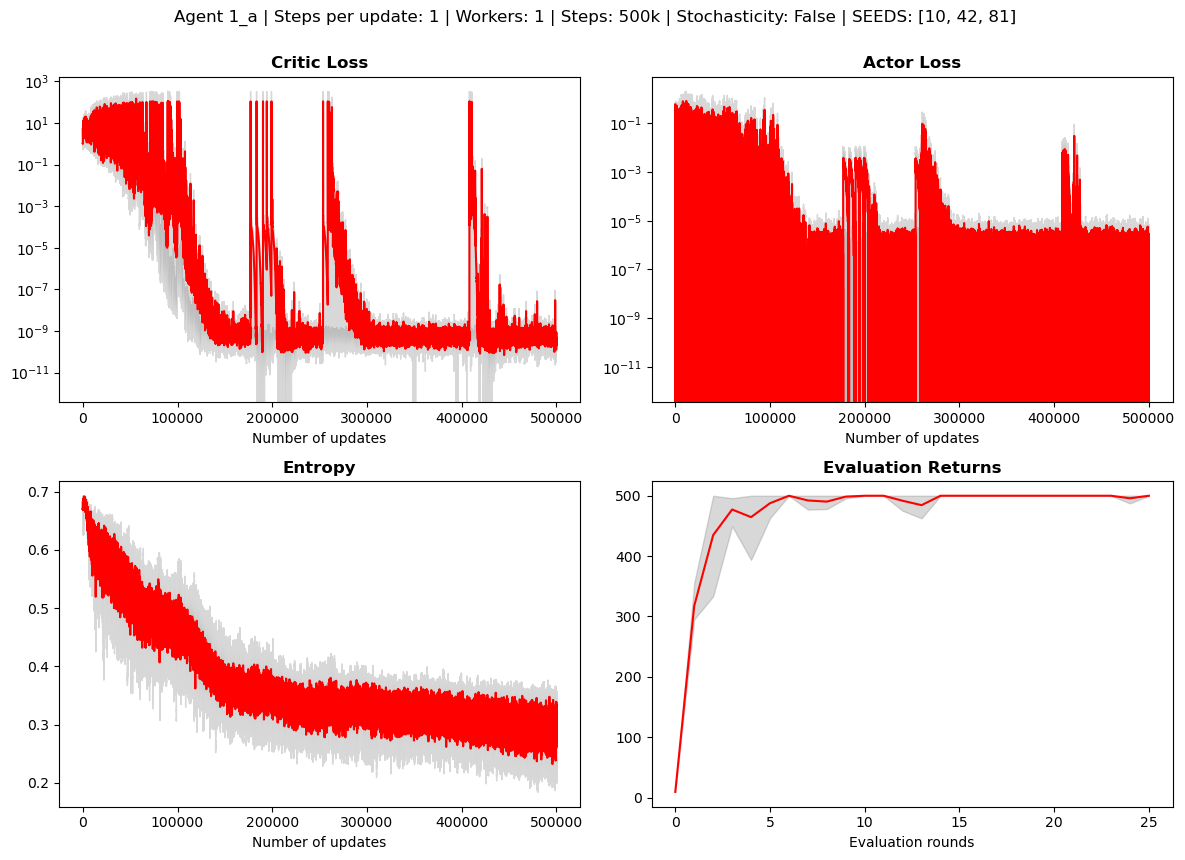

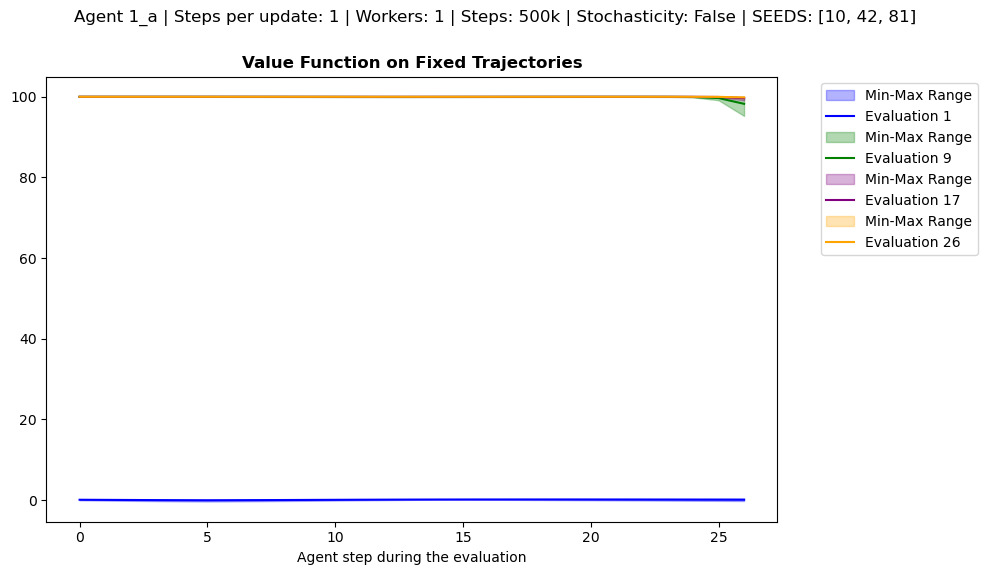

In [4]:
# Aggregate function for plotting the 3 seeds together
def aggregate_plot(y1,y2,y3):
    """
    Aggregates three input curves by computing the element-wise minimum, maximum, and average.

    Parameters:
    y1, y2, y3: np.ndarray
        Input arrays representing the three curves to be aggregated. Each array should have the same shape.

    Returns:
    y_min, y_max, y_avg: np.ndarray
        The element-wise minimum / maximum / average of the three input curves.
    """

    # Compute minimum and maximum curves
    y_min = np.minimum(np.minimum(y1, y2), y3)
    y_max = np.maximum(np.maximum(y1, y2), y3)

    # Compute average curve
    y_avg = (y1 + y2 + y3) / 3

    return y_min, y_max, y_avg

rolling_length = 30 # Rolling length for the convolution

# Arrays for the value function trajectories
values_arr = np.array(values) # Transforming the list to a numpy array ==> Values_arr of size (n_seeds, n_eval_done, steps_in_trajectory, 1)
values_sq = np.squeeze(values_arr) # Now of size (n_seeds, n_eval_done, steps_in_trajectory)
n_eval_done = values_sq.shape[1] # Number of evaluations done 
steps_in_trajectory = values_sq.shape[2] # Amount of steps in the trajectories of the value function
n_traj = 4 # Amount of value function trajectories to be plotted

# The code below is to select n_traj evenly spaced trajectories to plot between the first and last evaluation
if n_eval_done >= n_traj:
    idx_traj = np.linspace(0, n_eval_done - 1, n_traj, dtype='int') # Selecting n_traj trajectories evenly spaced between the first and last
else:
    idx_traj = np.arange(n_eval_done) # in case there are less evaluations than trajectories to plot, plot all evaluations

n_traj = len(idx_traj) # No matter how many trajectories where found, n_traj is updated to the actual length of the idx_traj
val_array = np.zeros((n_seeds, n_traj, steps_in_trajectory)) # Array to store the values of the selected trajectories
val_array = values_sq[:,idx_traj] # of size n_seeds, n_traj, steps_in_trajectory => contains only the values of the selected trajectories

traj_aggregates = np.zeros((n_seeds, n_traj, steps_in_trajectory)) # Will receive the values of y_min, y_max and y_avg for each of the n_traj for each seed


# Creating the lists for the aggregation
critic_y =[[] for _ in range(n_seeds)]
actor_y =[[] for _ in range(n_seeds)]
entropy_y =[[] for _ in range(n_seeds)]
evaluation_returns_seeds = np.array(evaluation_returns_seeds)


# Aggregating the losses and entropy while performing convolution
for s, agent_seed in enumerate(agents_seeds):
    critic_y[s] = (
        np.convolve(np.array(critic_losses[:,s]), np.ones(rolling_length), mode="valid")
        / rolling_length)
    actor_y[s] = (
        np.convolve(np.array(actor_losses[:,s]), np.ones(rolling_length), mode="valid")
        / rolling_length)
    entropy_y[s] = (
        np.convolve(np.array(entropies[:,s]), np.ones(rolling_length), mode="valid")
        / rolling_length
    )
    
# Building the y_min, y_max and y_avg for each of the plots
critic_y_min, critic_y_max, critic_y_avg = aggregate_plot(critic_y[0],critic_y[1],critic_y[2])
actor_y_min, actor_y_max, actor_y_avg = aggregate_plot(actor_y[0],actor_y[1],actor_y[2])
entropy_y_min, entropy_y_max, entropy_y_avg = aggregate_plot(entropy_y[0],entropy_y[1],entropy_y[2])
reward_y_min, reward_y_max, reward_y_avg = aggregate_plot(evaluation_returns_seeds[0], evaluation_returns_seeds[1], evaluation_returns_seeds[2])

# x values for the plots
critic_x = np.arange(0, critic_y_min.shape[0])
actor_x = np.arange(0, actor_y_min.shape[0]) # Not necessary
entropy_x = np.arange(0, entropy_y_min.shape[0]) # Not necessary
reward_x = np.arange(0, reward_y_min.shape[0])
traj_x = np.arange(0, steps_in_trajectory)
#ep_return_x = np.arange(0, ep_return_y_min.shape[0])
for j in range(n_traj): # Storing the y_min, y_max and y_avg of each of the n_traj trajectories
    traj_aggregates[0,j], traj_aggregates[1,j], traj_aggregates[2,j], = aggregate_plot(val_array[0][j], val_array[1][j], val_array[2][j])

""" Plotting the losses, entropy and returns"""
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 9))
fig.suptitle(f"Agent {id_agent} | Steps per update: {n_steps_per_update} | Workers: {n_envs} | Steps: {n_steps//1000}k | Stochasticity: {stochasticity_bool} | SEEDS: {agents_seeds}", x=0.5, fontsize = 12)

# Critic loss
axs[0, 0].fill_between(critic_x,critic_y_min, critic_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[0, 0].plot(critic_x, critic_y_avg, color='red', label='Average Curve')
axs[0, 0].set_title('Critic Loss', fontweight='bold')
axs[0, 0].set_yscale('log')  # Set log scale for the y-axis
axs[0, 0].set_xlabel("Number of updates")

# Actor loss
axs[0, 1].fill_between(actor_x,actor_y_min, actor_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[0, 1].plot(actor_x, actor_y_avg, color='red', label='Average Curve')
axs[0, 1].set_title('Actor Loss', fontweight='bold')
axs[0, 1].set_yscale('log')  # Set log scale for the y-axis
axs[0, 1].set_xlabel("Number of updates")

# Entropy
axs[1, 0].fill_between(entropy_x,entropy_y_min, entropy_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[1, 0].plot(entropy_x, entropy_y_avg, color='red', label='Average Curve')
axs[1, 0].set_title("Entropy", fontweight='bold')
axs[1, 0].set_xlabel("Number of updates")

# Evaluation rewards
axs[1, 1].fill_between(reward_x,reward_y_min, reward_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[1, 1].plot(reward_x, reward_y_avg, color='red', label='Average Curve')
axs[1, 1].set_title('Evaluation Returns', fontweight='bold')
axs[1, 1].set_xlabel("Evaluation rounds")

#plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig(f'figures/Agent{id_agent}_Losses&Returns.png', bbox_inches='tight')
plt.show()


"""Plotting the value function along the predefined fixed trajectory"""

colors = ['blue', 'green', 'purple', 'orange', 'black', 'yellow', 'pink', 'brown', 'cyan', 'magenta']

plt.figure(figsize=(10, 6))

for j in range(len(idx_traj)):
    plt.fill_between(traj_x, traj_aggregates[0,j], traj_aggregates[1,j], color = colors[j], alpha=0.3, label='Min-Max Range')
    plt.plot(traj_x, traj_aggregates[2,j,:], color=colors[j], label=f"Evaluation {idx_traj[j]+1}")

plt.suptitle(f"Agent {id_agent} | Steps per update: {n_steps_per_update} | Workers: {n_envs} | Steps: {n_steps//1000}k | Stochasticity: {stochasticity_bool} | SEEDS: {agents_seeds}", x=0.5, fontsize = 12)
plt.title('Value Function on Fixed Trajectories', fontweight='bold')
plt.xlabel('Agent step during the evaluation')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig(f'figures/Agent{id_agent}_Trajectories.png', bbox_inches='tight')
#plt.savefig(f'figures/Agent{id_agent}_Trajectories-&-{n_steps//1000}k_steps-&-{n_envs}_workers-&-{n_steps_per_update}_steps-per-update.png', bbox_inches='tight')
plt.show()

# Agent 1.b (K = 1 | n = 1 | Stochastic = True)

## 1.b.1 PARAMETERS SETUP


In [5]:
# utils functions 
def set_seed(seed):
    torch.manual_seed(seed) # pytorch random seed
    np.random.seed(seed) # numpy random seed

def getTrajectory():
    # create a new sample environment to get new random parameters
    env = gym.make("CartPole-v1", max_episode_steps=500)
    states = []
    # get an initial state
    state, info = env.reset(seed=40) # Seed n°40 allows to have the same sufficiently long trajectory across runs 
    states.append(state)
    done = False
    # play one episode
    done = False
    for i in range(5):
        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        state, reward, terminated, truncated, info = env.step(0) # only pushes left (0 is left, 1 is right)
        states.append(state)
    while not done:
        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        state, reward, terminated, truncated, info = env.step(1) # only pushes left (0 is left, 1 is right)
        states.append(state)
        done = terminated or truncated
        
    env.close()
    return states

# HYPERPARAMETERS
# environment hyperparams
n_steps = 500000
n_envs = 1
n_steps_per_update = 1
n_updates = n_steps // (n_steps_per_update*n_envs)
evaluation_interval = 20000//(n_steps_per_update*n_envs) # evaluate the agent every 20k steps
n_eval_runs = 10 # how many evaluation runs to do each 20k steps 
n_evaluations = n_updates // evaluation_interval

# Aggregate parameters
n_seeds = 3 # number of random seeds for the aggregation of plots
agents_seeds = [10, 42, 81] # Arbitrary seeds for the agents

# agent hyperparams
gamma = 0.99  # discount factor
ent_coef = 0.01  # coefficient for the entropy bonus (to encourage exploration)
actor_lr = 1e-5
critic_lr = 1e-3
stochasticity_bool = True
stochastic_reward_probability = 0.9
# Note: the actor has a slower learning rate so that the value targets become
# more stationary and are theirfore easier to estimate for the critic

# SEED
# Set a seed value
seed_value = 50
set_seed(seed_value)

# ENVIRONMENT
id_agent = "1_b" # ID of the Agent for the report [1:6]
envs = []
for i in range(n_envs):
    env = gym.make('CartPole-v1')
    envs.append(env)

env_eval = gym.make("CartPole-v1")
obs_shape = env_eval.observation_space.shape[0]
action_shape = env_eval.action_space.n

# DEVICE
use_cuda = False
if use_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

## 1.b.2 AGENT TRAINING

In [6]:
# LOGGED VARIABLES

# per seed
critic_losses = np.zeros((n_updates+1, n_seeds))
actor_losses = np.zeros((n_updates+1, n_seeds))
entropies = np.zeros((n_updates+1, n_seeds))
values = [[] for _ in range(n_seeds)] # logs the values of the agent on the fixed trajectory
evaluation_returns_seeds = [[] for _ in range(n_seeds)]

# per worker (not used in the plots)
episode_returns = [[] for _ in range(n_envs)] # logs the returns per episode per worker
steps_episodes = [[] for _ in range(n_envs)] # logs the steps taken in each episode per worker


fixed_trajectory = getTrajectory()

for s, agent_seed in enumerate(agents_seeds):
    print(f"Running seed {agent_seed} for agent {s}")
    agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr, n_envs)

    # COUNTERS
    steps = 0
    steps_workers = [0] * n_envs
    ep_counter = 0
    ep_reward = [0] * n_envs

    # VARIABLE INITIALIZATION
    is_truncated = [False] * n_envs #creates a list of n_envs elements, all set to False
    is_terminated = [False] * n_envs #creates a list of n_envs elements, all set to False
    states = []

    set_seed(agent_seed)
    for i in range(n_envs):
        state, info = envs[i].reset(seed=agent_seed)  #only use the seed when resetting the first time
        states.append(state)


    # use tqdm to get a progress bar for training
    for steps in tqdm(range(n_updates+1)):
            

        # reset lists that collect experiences of a n_steps_per_update
        n_value_preds = torch.zeros(n_steps_per_update, n_envs, device=device)
        n_action_log_probs = torch.zeros(n_steps_per_update, n_envs, device=device)
        # don't take mask and reward gradient
        masks = torch.ones(n_steps_per_update, n_envs, device=device,requires_grad = False)
        n_rewards = torch.zeros(n_steps_per_update, n_envs, device=device,requires_grad = False)
        end_states = [[] for _ in range(n_envs)] # get a list for each env ex : [[], [], []]
        end_states_idx = [[0] for _ in range(n_envs)] # get a list for each env ex : [[0], [0], [0]]

        # play n_steps_per_update to collect data
        for step in range(n_steps_per_update):
            entropy = [0] * n_envs
            for env_idx in range(n_envs):
                # select an action A_{t} using S_{t} as input for the agent, get action and values Vt
                action, action_log_probs, V_t, entropy[env_idx] = agent.select_action(states[env_idx], bool_greedy=False)

                # ensure no grad is taken in the step
                with torch.no_grad():
                    # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
                    states[env_idx], reward, is_terminated[env_idx], is_truncated[env_idx], infos = envs[env_idx].step(
                        action.cpu().numpy()
                    )
                    steps_workers[env_idx] += 1
                if stochasticity_bool:
                    # introduce stochasticity in the reward
                    if np.random.rand() < stochastic_reward_probability:
                        reward = 0

                ep_reward[env_idx] += reward # increase episode return
                mask = not is_terminated[env_idx] # define mask for bootstrapping

                # log the value, reward and action log prob of the last step
                n_value_preds[step][env_idx] = torch.squeeze(V_t)
                n_rewards[step][env_idx] = torch.tensor(reward, device=device)
                n_action_log_probs[step][env_idx] = action_log_probs

                # for each env the mask is 1 if the episode is ongoing and 0 if it is terminated (not by truncation!)
                masks[step][env_idx] = torch.tensor(mask) # allows for correct bootstrapping
                
                # reset environment if truncated or terminated
                if is_terminated[env_idx] or is_truncated[env_idx]:
                    states_tensor = torch.tensor(states[env_idx], device=device) # Transform the last state reached (S_t+n) to a tensor
                    end_states[env_idx].append(states_tensor)
                    end_states_idx[env_idx].append(step)
                    states[env_idx], info = envs[env_idx].reset() # do not use the seed when resetting again
                    ep_counter += 1
                    steps_episodes[env_idx].append(steps_workers[env_idx])
                    episode_returns[env_idx].append(ep_reward[env_idx])
                    ep_reward[env_idx] = 0

        
        for env_idx in range(n_envs):
            # if statement to make sure we don't append the end state twice
            if not is_terminated[env_idx] and not is_truncated[env_idx]:
                states_tensor = torch.tensor(states[env_idx], device=device) # Transform the last state reached (S_t+n) to a tensor
                end_states[env_idx].append(states_tensor)
                end_states_idx[env_idx].append(step)

        # calculate the losses for actor and critic
        critic_loss, actor_loss = agent.get_losses(
            n_rewards,
            n_action_log_probs,
            n_value_preds,
            entropy,
            masks,
            gamma,
            end_states,
            end_states_idx
        )

        # update the actor and critic networks
        agent.update_parameters(critic_loss, actor_loss)


        # log the losses and entropy
        critic_losses[steps, s] = critic_loss.detach().cpu().numpy()
        actor_losses[steps, s] = actor_loss.detach().cpu().numpy()
        entropies[steps, s] = sum(entropy) / len(entropy)


        #After every 20k steps, evaluate the performance of your agent by running it for 10 episodes with a greedy action policy (without noise)
        #on a newly initialized environment and plotting the evaluation statistics below.
        with torch.no_grad(): # No need to store gradients in the evaluation
            if steps % evaluation_interval == 0:
                print("EVALUATION")
                # evaluate
                returns = []
                episode_lengths = []
                for i in range(n_eval_runs):
                    # Only use the seed when resetting at the beginning to ensure the states will follow the same initialization at every evalutaion step
                    if i == 0:
                        state, info = env_eval.reset(seed = agent_seed)
                        value = []
                        for state_traj in fixed_trajectory:
                            _, _, V_t, _ = agent.select_action(state_traj, bool_greedy=False)
                            value.append(V_t)
                        values[s].append(value)
                        
                    else:
                        state, info = env_eval.reset()
                    episode_return = 0
                    episode_length = 0
                    while True:
                        action, _, _, _ = agent.select_action(state,bool_greedy=True)
                        state, reward, terminated, truncated, info = env_eval.step(action.cpu().numpy())
                        episode_return += reward
                        episode_length += 1
                        if terminated or truncated:
                            break
                    returns.append(episode_return)
                    episode_lengths.append(episode_length)  
                evaluation_returns_seeds[s].append(np.mean(returns))
                
# Logging variables for each agent
values_agent_1b = values.copy()
critic_losses_agent_1b = critic_losses.copy()
actor_losses_agent_1b = actor_losses.copy()
entropies_agent_1b = entropies.copy()
evaluation_returns_seeds_agent_1b = evaluation_returns_seeds.copy()
                





Running seed 10 for agent 0


  0%|          | 94/500001 [00:00<08:54, 936.01it/s]

EVALUATION


  4%|▍         | 19894/500001 [00:15<06:02, 1326.06it/s]

EVALUATION


  8%|▊         | 39962/500001 [00:32<05:50, 1311.81it/s]

EVALUATION


 12%|█▏        | 59964/500001 [00:49<06:07, 1197.87it/s]

EVALUATION


 16%|█▌        | 79924/500001 [01:06<05:15, 1332.56it/s]

EVALUATION


 20%|█▉        | 99945/500001 [01:22<05:13, 1277.95it/s]

EVALUATION


 24%|██▍       | 119910/500001 [01:39<04:51, 1302.27it/s]

EVALUATION


 28%|██▊       | 139914/500001 [01:55<04:39, 1290.44it/s]

EVALUATION


 32%|███▏      | 159952/500001 [02:11<04:30, 1256.56it/s]

EVALUATION


 36%|███▌      | 179967/500001 [02:27<04:36, 1157.08it/s]

EVALUATION


 40%|███▉      | 199970/500001 [02:43<03:54, 1277.60it/s]

EVALUATION


 44%|████▍     | 219959/500001 [02:59<03:28, 1345.07it/s]

EVALUATION


 48%|████▊     | 239939/500001 [03:15<03:24, 1268.72it/s]

EVALUATION


 52%|█████▏    | 259904/500001 [03:31<03:10, 1262.99it/s]

EVALUATION


 56%|█████▌    | 279969/500001 [03:47<02:42, 1355.11it/s]

EVALUATION


 60%|█████▉    | 299926/500001 [04:03<02:33, 1299.71it/s]

EVALUATION


 64%|██████▍   | 319969/500001 [04:19<02:33, 1169.63it/s]

EVALUATION


 68%|██████▊   | 339987/500001 [04:35<01:59, 1343.77it/s]

EVALUATION


 72%|███████▏  | 359993/500001 [04:51<01:41, 1382.15it/s]

EVALUATION


 76%|███████▌  | 379909/500001 [05:06<01:33, 1283.88it/s]

EVALUATION


 80%|████████  | 400030/500001 [05:23<01:44, 954.41it/s] 

EVALUATION


 84%|████████▍ | 419892/500001 [05:38<01:04, 1241.03it/s]

EVALUATION


 88%|████████▊ | 439889/500001 [05:55<00:50, 1201.51it/s]

EVALUATION


 92%|█████████▏| 459972/500001 [06:11<00:28, 1380.95it/s]

EVALUATION


 96%|█████████▌| 479901/500001 [06:27<00:15, 1312.10it/s]

EVALUATION


100%|█████████▉| 499991/500001 [06:43<00:00, 1296.90it/s]

EVALUATION


100%|██████████| 500001/500001 [06:44<00:00, 1237.43it/s]


Running seed 42 for agent 1


  0%|          | 93/500001 [00:00<08:59, 927.40it/s]

EVALUATION


  4%|▍         | 19876/500001 [00:15<06:23, 1251.65it/s]

EVALUATION


  8%|▊         | 39934/500001 [00:31<05:59, 1280.17it/s]

EVALUATION


 12%|█▏        | 59997/500001 [00:47<05:40, 1293.10it/s]

EVALUATION


 16%|█▌        | 79923/500001 [01:03<05:10, 1353.83it/s]

EVALUATION


 20%|█▉        | 99977/500001 [01:19<05:12, 1280.87it/s]

EVALUATION


 24%|██▍       | 119906/500001 [01:34<04:58, 1272.49it/s]

EVALUATION


 28%|██▊       | 139946/500001 [01:50<04:27, 1344.64it/s]

EVALUATION


 32%|███▏      | 159868/500001 [02:07<04:14, 1337.52it/s]

EVALUATION


 36%|███▌      | 179949/500001 [02:23<04:20, 1226.49it/s]

EVALUATION


 40%|███▉      | 199865/500001 [02:39<03:46, 1325.66it/s]

EVALUATION


 44%|████▍     | 219952/500001 [02:55<03:38, 1280.71it/s]

EVALUATION


 48%|████▊     | 239937/500001 [03:12<04:08, 1047.29it/s]

EVALUATION


 52%|█████▏    | 259912/500001 [03:29<03:05, 1292.51it/s]

EVALUATION


 56%|█████▌    | 279927/500001 [03:45<02:59, 1227.54it/s]

EVALUATION


 60%|█████▉    | 299988/500001 [04:02<02:38, 1260.22it/s]

EVALUATION


 64%|██████▍   | 319973/500001 [04:19<02:22, 1264.06it/s]

EVALUATION


 68%|██████▊   | 339993/500001 [04:35<02:17, 1160.13it/s]

EVALUATION


 72%|███████▏  | 359893/500001 [04:53<01:51, 1256.63it/s]

EVALUATION


 76%|███████▌  | 379886/500001 [05:09<01:35, 1255.77it/s]

EVALUATION


 80%|███████▉  | 399916/500001 [05:25<01:18, 1278.46it/s]

EVALUATION


 84%|████████▍ | 419935/500001 [05:42<01:04, 1246.26it/s]

EVALUATION


 88%|████████▊ | 439951/500001 [05:58<00:45, 1334.28it/s]

EVALUATION


 92%|█████████▏| 459957/500001 [06:13<00:29, 1341.25it/s]

EVALUATION


 96%|█████████▌| 479887/500001 [06:29<00:15, 1331.69it/s]

EVALUATION


100%|█████████▉| 499970/500001 [06:45<00:00, 1376.06it/s]

EVALUATION


100%|██████████| 500001/500001 [06:45<00:00, 1232.37it/s]


Running seed 81 for agent 2


  0%|          | 118/500001 [00:00<07:05, 1174.96it/s]

EVALUATION


  4%|▍         | 19875/500001 [00:14<05:45, 1387.94it/s]

EVALUATION


  8%|▊         | 39888/500001 [00:30<05:31, 1386.13it/s]

EVALUATION


 12%|█▏        | 59882/500001 [00:45<05:18, 1380.60it/s]

EVALUATION


 16%|█▌        | 79912/500001 [01:00<05:04, 1380.66it/s]

EVALUATION


 20%|█▉        | 99913/500001 [01:16<05:29, 1214.76it/s]

EVALUATION


 24%|██▍       | 119898/500001 [01:33<05:01, 1260.11it/s]

EVALUATION


 28%|██▊       | 139988/500001 [01:48<04:24, 1362.52it/s]

EVALUATION


 32%|███▏      | 159900/500001 [02:04<04:11, 1353.61it/s]

EVALUATION


 36%|███▌      | 179980/500001 [02:19<03:48, 1401.44it/s]

EVALUATION


 40%|███▉      | 199884/500001 [02:34<03:42, 1347.86it/s]

EVALUATION


 44%|████▍     | 219879/500001 [02:50<03:36, 1296.21it/s]

EVALUATION


 48%|████▊     | 239869/500001 [03:06<03:06, 1397.51it/s]

EVALUATION


 52%|█████▏    | 259875/500001 [03:21<02:51, 1398.09it/s]

EVALUATION


 56%|█████▌    | 279999/500001 [03:36<02:43, 1345.94it/s]

EVALUATION


 60%|█████▉    | 299928/500001 [03:52<02:35, 1289.34it/s]

EVALUATION


 64%|██████▍   | 319947/500001 [04:08<02:19, 1294.27it/s]

EVALUATION


 68%|██████▊   | 339984/500001 [04:25<02:07, 1250.18it/s]

EVALUATION


 72%|███████▏  | 359865/500001 [04:40<01:41, 1377.15it/s]

EVALUATION


 76%|███████▌  | 380013/500001 [04:55<02:10, 920.70it/s] 

EVALUATION


 80%|███████▉  | 399905/500001 [05:10<01:17, 1284.82it/s]

EVALUATION


 84%|████████▍ | 420109/500001 [05:26<01:18, 1011.44it/s]

EVALUATION


 88%|████████▊ | 439982/500001 [05:41<00:43, 1372.45it/s]

EVALUATION


 92%|█████████▏| 459991/500001 [05:56<00:29, 1360.64it/s]

EVALUATION


 96%|█████████▌| 479911/500001 [06:11<00:14, 1350.08it/s]

EVALUATION


100%|█████████▉| 499985/500001 [06:26<00:00, 1181.80it/s]

EVALUATION


100%|██████████| 500001/500001 [06:27<00:00, 1291.40it/s]


## 1.b.3 PLOTTING

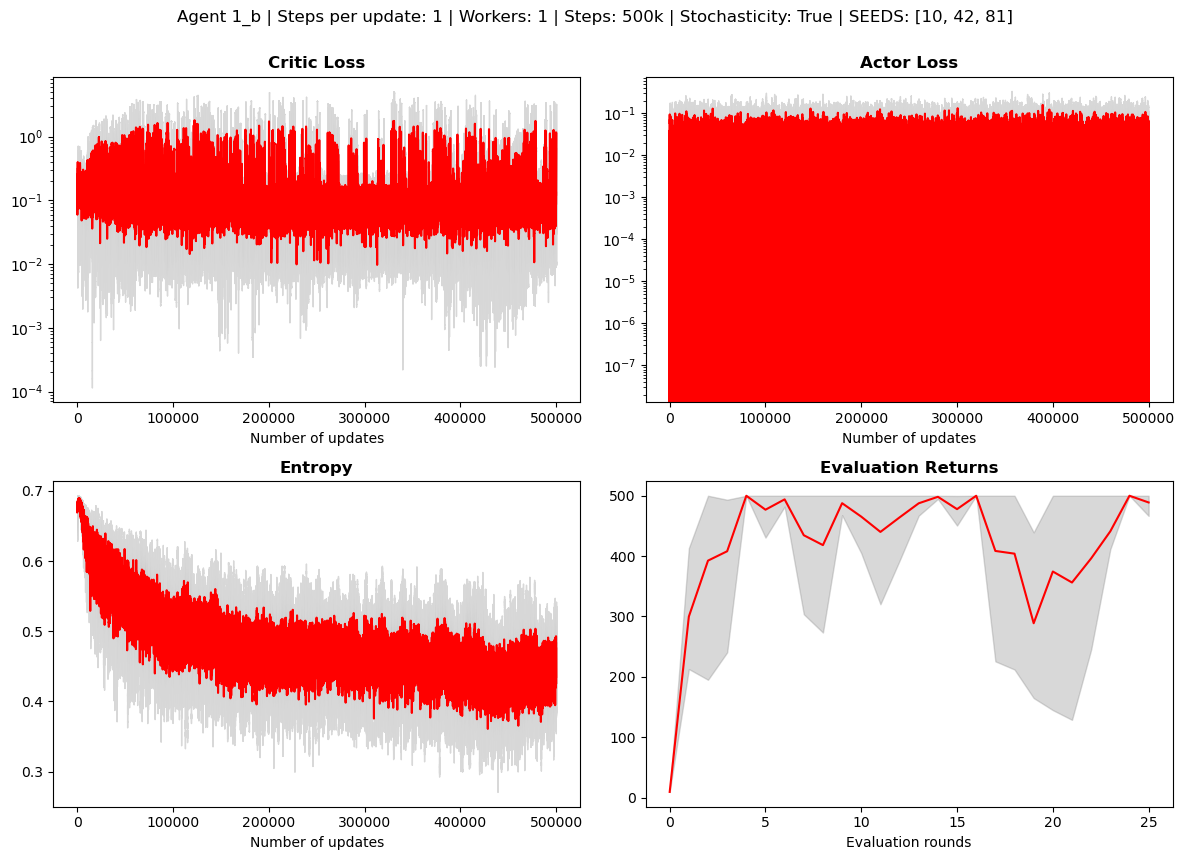

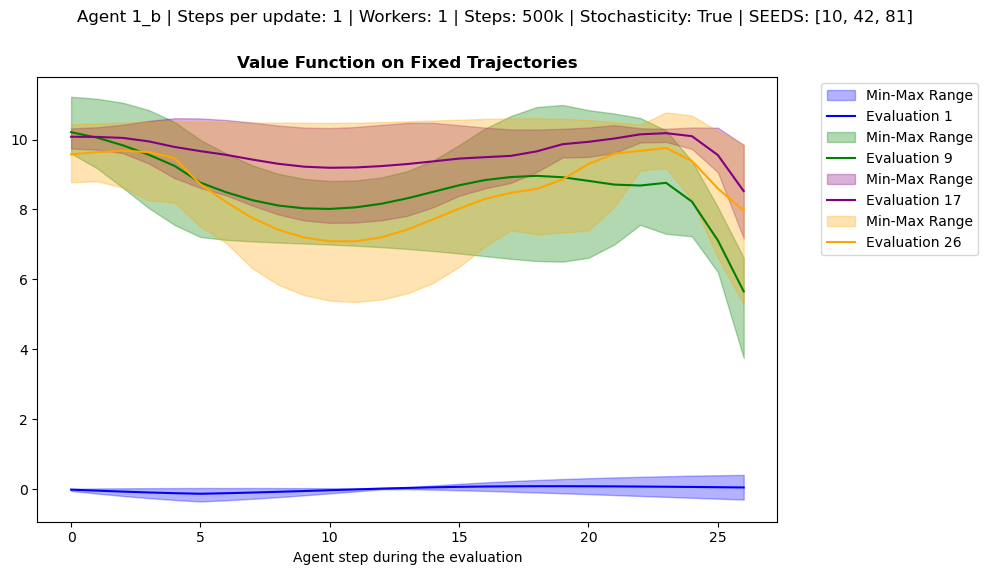

In [7]:
# Aggregate function for plotting the 3 seeds together
def aggregate_plot(y1,y2,y3):
    """
    Aggregates three input curves by computing the element-wise minimum, maximum, and average.

    Parameters:
    y1, y2, y3: np.ndarray
        Input arrays representing the three curves to be aggregated. Each array should have the same shape.

    Returns:
    y_min, y_max, y_avg: np.ndarray
        The element-wise minimum / maximum / average of the three input curves.
    """

    # Compute minimum and maximum curves
    y_min = np.minimum(np.minimum(y1, y2), y3)
    y_max = np.maximum(np.maximum(y1, y2), y3)

    # Compute average curve
    y_avg = (y1 + y2 + y3) / 3

    return y_min, y_max, y_avg

rolling_length = 30 # Rolling length for the convolution

# Arrays for the value function trajectories
values_arr = np.array(values) # Transforming the list to a numpy array ==> Values_arr of size (n_seeds, n_eval_done, steps_in_trajectory, 1)
values_sq = np.squeeze(values_arr) # Now of size (n_seeds, n_eval_done, steps_in_trajectory)
n_eval_done = values_sq.shape[1] # Number of evaluations done 
steps_in_trajectory = values_sq.shape[2] # Amount of steps in the trajectories of the value function
n_traj = 4 # Amount of value function trajectories to be plotted

# The code below is to select n_traj evenly spaced trajectories to plot between the first and last evaluation
if n_eval_done >= n_traj:
    idx_traj = np.linspace(0, n_eval_done - 1, n_traj, dtype='int') # Selecting n_traj trajectories evenly spaced between the first and last
else:
    idx_traj = np.arange(n_eval_done) # in case there are less evaluations than trajectories to plot, plot all evaluations

n_traj = len(idx_traj) # No matter how many trajectories where found, n_traj is updated to the actual length of the idx_traj
val_array = np.zeros((n_seeds, n_traj, steps_in_trajectory)) # Array to store the values of the selected trajectories
val_array = values_sq[:,idx_traj] # of size n_seeds, n_traj, steps_in_trajectory => contains only the values of the selected trajectories

traj_aggregates = np.zeros((n_seeds, n_traj, steps_in_trajectory)) # Will receive the values of y_min, y_max and y_avg for each of the n_traj for each seed


# Creating the lists for the aggregation
critic_y =[[] for _ in range(n_seeds)]
actor_y =[[] for _ in range(n_seeds)]
entropy_y =[[] for _ in range(n_seeds)]
evaluation_returns_seeds = np.array(evaluation_returns_seeds)


# Aggregating the losses and entropy while performing convolution
for s, agent_seed in enumerate(agents_seeds):
    critic_y[s] = (
        np.convolve(np.array(critic_losses[:,s]), np.ones(rolling_length), mode="valid")
        / rolling_length)
    actor_y[s] = (
        np.convolve(np.array(actor_losses[:,s]), np.ones(rolling_length), mode="valid")
        / rolling_length)
    entropy_y[s] = (
        np.convolve(np.array(entropies[:,s]), np.ones(rolling_length), mode="valid")
        / rolling_length
    )
    
# Building the y_min, y_max and y_avg for each of the plots
critic_y_min, critic_y_max, critic_y_avg = aggregate_plot(critic_y[0],critic_y[1],critic_y[2])
actor_y_min, actor_y_max, actor_y_avg = aggregate_plot(actor_y[0],actor_y[1],actor_y[2])
entropy_y_min, entropy_y_max, entropy_y_avg = aggregate_plot(entropy_y[0],entropy_y[1],entropy_y[2])
reward_y_min, reward_y_max, reward_y_avg = aggregate_plot(evaluation_returns_seeds[0], evaluation_returns_seeds[1], evaluation_returns_seeds[2])

# x values for the plots
critic_x = np.arange(0, critic_y_min.shape[0])
actor_x = np.arange(0, actor_y_min.shape[0]) # Not necessary
entropy_x = np.arange(0, entropy_y_min.shape[0]) # Not necessary
reward_x = np.arange(0, reward_y_min.shape[0])
traj_x = np.arange(0, steps_in_trajectory)
#ep_return_x = np.arange(0, ep_return_y_min.shape[0])
for j in range(n_traj): # Storing the y_min, y_max and y_avg of each of the n_traj trajectories
    traj_aggregates[0,j], traj_aggregates[1,j], traj_aggregates[2,j], = aggregate_plot(val_array[0][j], val_array[1][j], val_array[2][j])

""" Plotting the losses, entropy and returns"""
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 9))
fig.suptitle(f"Agent {id_agent} | Steps per update: {n_steps_per_update} | Workers: {n_envs} | Steps: {n_steps//1000}k | Stochasticity: {stochasticity_bool} | SEEDS: {agents_seeds}", x=0.5, fontsize = 12)

# Critic loss
axs[0, 0].fill_between(critic_x,critic_y_min, critic_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[0, 0].plot(critic_x, critic_y_avg, color='red', label='Average Curve')
axs[0, 0].set_title('Critic Loss', fontweight='bold')
axs[0, 0].set_yscale('log')  # Set log scale for the y-axis
axs[0, 0].set_xlabel("Number of updates")

# Actor loss
axs[0, 1].fill_between(actor_x,actor_y_min, actor_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[0, 1].plot(actor_x, actor_y_avg, color='red', label='Average Curve')
axs[0, 1].set_title('Actor Loss', fontweight='bold')
axs[0, 1].set_yscale('log')  # Set log scale for the y-axis
axs[0, 1].set_xlabel("Number of updates")

# Entropy
axs[1, 0].fill_between(entropy_x,entropy_y_min, entropy_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[1, 0].plot(entropy_x, entropy_y_avg, color='red', label='Average Curve')
axs[1, 0].set_title("Entropy", fontweight='bold')
axs[1, 0].set_xlabel("Number of updates")

# Evaluation rewards
axs[1, 1].fill_between(reward_x,reward_y_min, reward_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[1, 1].plot(reward_x, reward_y_avg, color='red', label='Average Curve')
axs[1, 1].set_title('Evaluation Returns', fontweight='bold')
axs[1, 1].set_xlabel("Evaluation rounds")

#plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig(f'figures/Agent{id_agent}_Losses&Returns.png', bbox_inches='tight')
plt.show()


"""Plotting the value function along the predefined fixed trajectory"""

colors = ['blue', 'green', 'purple', 'orange', 'black', 'yellow', 'pink', 'brown', 'cyan', 'magenta']

plt.figure(figsize=(10, 6))

for j in range(len(idx_traj)):
    plt.fill_between(traj_x, traj_aggregates[0,j], traj_aggregates[1,j], color = colors[j], alpha=0.3, label='Min-Max Range')
    plt.plot(traj_x, traj_aggregates[2,j,:], color=colors[j], label=f"Evaluation {idx_traj[j]+1}")

plt.suptitle(f"Agent {id_agent} | Steps per update: {n_steps_per_update} | Workers: {n_envs} | Steps: {n_steps//1000}k | Stochasticity: {stochasticity_bool} | SEEDS: {agents_seeds}", x=0.5, fontsize = 12)
plt.title('Value Function on Fixed Trajectories', fontweight='bold')
plt.xlabel('Agent step during the evaluation')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig(f'figures/Agent{id_agent}_Trajectories.png', bbox_inches='tight')
#plt.savefig(f'figures/Agent{id_agent}_Trajectories-&-{n_steps//1000}k_steps-&-{n_envs}_workers-&-{n_steps_per_update}_steps-per-update.png', bbox_inches='tight')
plt.show()

# Agent 2 (K = 6 | n = 1)

## 2.1 PARAMETERS SETUP


In [8]:
# utils functions 
def set_seed(seed):
    torch.manual_seed(seed) # pytorch random seed
    np.random.seed(seed) # numpy random seed

def getTrajectory():
    # create a new sample environment to get new random parameters
    env = gym.make("CartPole-v1", max_episode_steps=500)
    states = []
    # get an initial state
    state, info = env.reset(seed=40) # Seed n°40 allows to have the same sufficiently long trajectory across runs 
    states.append(state)
    done = False
    # play one episode
    done = False
    for i in range(5):
        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        state, reward, terminated, truncated, info = env.step(0) # only pushes left (0 is left, 1 is right)
        states.append(state)
    while not done:
        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        state, reward, terminated, truncated, info = env.step(1) # only pushes left (0 is left, 1 is right)
        states.append(state)
        done = terminated or truncated
        
    env.close()
    return states

# HYPERPARAMETERS
# environment hyperparams
n_steps = 500000
n_envs = 6
n_steps_per_update = 1
n_updates = n_steps // (n_steps_per_update*n_envs)
evaluation_interval = 20000//(n_steps_per_update*n_envs) # evaluate the agent every 20k steps
n_eval_runs = 10 # how many evaluation runs to do each 20k steps 
n_evaluations = n_updates // evaluation_interval

# Aggregate parameters
n_seeds = 3 # number of random seeds for the aggregation of plots
agents_seeds = [10, 42, 81] # Arbitrary seeds for the agents

# agent hyperparams
gamma = 0.99  # discount factor
ent_coef = 0.01  # coefficient for the entropy bonus (to encourage exploration)
actor_lr = 1e-5
critic_lr = 1e-3
stochasticity_bool = True
stochastic_reward_probability = 0.9
# Note: the actor has a slower learning rate so that the value targets become
# more stationary and are theirfore easier to estimate for the critic

# SEED
# Set a seed value
seed_value = 50
set_seed(seed_value)

# ENVIRONMENT
id_agent = "2" # ID of the Agent for the report [1:6]
envs = []
for i in range(n_envs):
    env = gym.make('CartPole-v1')
    envs.append(env)

env_eval = gym.make("CartPole-v1")
obs_shape = env_eval.observation_space.shape[0]
action_shape = env_eval.action_space.n

# DEVICE
use_cuda = False
if use_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

## 2.2 AGENT TRAINING

In [9]:
# LOGGED VARIABLES

# per seed
critic_losses = np.zeros((n_updates+1, n_seeds))
actor_losses = np.zeros((n_updates+1, n_seeds))
entropies = np.zeros((n_updates+1, n_seeds))
values = [[] for _ in range(n_seeds)] # logs the values of the agent on the fixed trajectory
evaluation_returns_seeds = [[] for _ in range(n_seeds)]

# per worker (not used in the plots)
episode_returns = [[] for _ in range(n_envs)] # logs the returns per episode per worker
steps_episodes = [[] for _ in range(n_envs)] # logs the steps taken in each episode per worker


fixed_trajectory = getTrajectory()

for s, agent_seed in enumerate(agents_seeds):
    print(f"Running seed {agent_seed} for agent {s}")
    agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr, n_envs)

    # COUNTERS
    steps = 0
    steps_workers = [0] * n_envs
    ep_counter = 0
    ep_reward = [0] * n_envs

    # VARIABLE INITIALIZATION
    is_truncated = [False] * n_envs #creates a list of n_envs elements, all set to False
    is_terminated = [False] * n_envs #creates a list of n_envs elements, all set to False
    states = []

    set_seed(agent_seed)
    for i in range(n_envs):
        state, info = envs[i].reset(seed=agent_seed)  #only use the seed when resetting the first time
        states.append(state)


    # use tqdm to get a progress bar for training
    for steps in tqdm(range(n_updates+1)):
            

        # reset lists that collect experiences of a n_steps_per_update
        n_value_preds = torch.zeros(n_steps_per_update, n_envs, device=device)
        n_action_log_probs = torch.zeros(n_steps_per_update, n_envs, device=device)
        # don't take mask and reward gradient
        masks = torch.ones(n_steps_per_update, n_envs, device=device,requires_grad = False)
        n_rewards = torch.zeros(n_steps_per_update, n_envs, device=device,requires_grad = False)
        end_states = [[] for _ in range(n_envs)] # get a list for each env ex : [[], [], []]
        end_states_idx = [[0] for _ in range(n_envs)] # get a list for each env ex : [[0], [0], [0]]

        # play n_steps_per_update to collect data
        for step in range(n_steps_per_update):
            entropy = [0] * n_envs
            for env_idx in range(n_envs):
                # select an action A_{t} using S_{t} as input for the agent, get action and values Vt
                action, action_log_probs, V_t, entropy[env_idx] = agent.select_action(states[env_idx], bool_greedy=False)

                # ensure no grad is taken in the step
                with torch.no_grad():
                    # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
                    states[env_idx], reward, is_terminated[env_idx], is_truncated[env_idx], infos = envs[env_idx].step(
                        action.cpu().numpy()
                    )
                    steps_workers[env_idx] += 1
                if stochasticity_bool:
                    # introduce stochasticity in the reward
                    if np.random.rand() < stochastic_reward_probability:
                        reward = 0

                ep_reward[env_idx] += reward # increase episode return
                mask = not is_terminated[env_idx] # define mask for bootstrapping

                # log the value, reward and action log prob of the last step
                n_value_preds[step][env_idx] = torch.squeeze(V_t)
                n_rewards[step][env_idx] = torch.tensor(reward, device=device)
                n_action_log_probs[step][env_idx] = action_log_probs

                # for each env the mask is 1 if the episode is ongoing and 0 if it is terminated (not by truncation!)
                masks[step][env_idx] = torch.tensor(mask) # allows for correct bootstrapping
                
                # reset environment if truncated or terminated
                if is_terminated[env_idx] or is_truncated[env_idx]:
                    states_tensor = torch.tensor(states[env_idx], device=device) # Transform the last state reached (S_t+n) to a tensor
                    end_states[env_idx].append(states_tensor)
                    end_states_idx[env_idx].append(step)
                    states[env_idx], info = envs[env_idx].reset() # do not use the seed when resetting again
                    ep_counter += 1
                    steps_episodes[env_idx].append(steps_workers[env_idx])
                    episode_returns[env_idx].append(ep_reward[env_idx])
                    ep_reward[env_idx] = 0

        
        for env_idx in range(n_envs):
            # if statement to make sure we don't append the end state twice
            if not is_terminated[env_idx] and not is_truncated[env_idx]:
                states_tensor = torch.tensor(states[env_idx], device=device) # Transform the last state reached (S_t+n) to a tensor
                end_states[env_idx].append(states_tensor)
                end_states_idx[env_idx].append(step)

        # calculate the losses for actor and critic
        critic_loss, actor_loss = agent.get_losses(
            n_rewards,
            n_action_log_probs,
            n_value_preds,
            entropy,
            masks,
            gamma,
            end_states,
            end_states_idx
        )

        # update the actor and critic networks
        agent.update_parameters(critic_loss, actor_loss)


        # log the losses and entropy
        critic_losses[steps, s] = critic_loss.detach().cpu().numpy()
        actor_losses[steps, s] = actor_loss.detach().cpu().numpy()
        entropies[steps, s] = sum(entropy) / len(entropy)


        #After every 20k steps, evaluate the performance of your agent by running it for 10 episodes with a greedy action policy (without noise)
        #on a newly initialized environment and plotting the evaluation statistics below.
        with torch.no_grad(): # No need to store gradients in the evaluation
            if steps % evaluation_interval == 0:
                print("EVALUATION")
                # evaluate
                returns = []
                episode_lengths = []
                for i in range(n_eval_runs):
                    # Only use the seed when resetting at the beginning to ensure the states will follow the same initialization at every evalutaion step
                    if i == 0:
                        state, info = env_eval.reset(seed = agent_seed)
                        value = []
                        for state_traj in fixed_trajectory:
                            _, _, V_t, _ = agent.select_action(state_traj, bool_greedy=False)
                            value.append(V_t)
                        values[s].append(value)
                        
                    else:
                        state, info = env_eval.reset()
                    episode_return = 0
                    episode_length = 0
                    while True:
                        action, _, _, _ = agent.select_action(state,bool_greedy=True)
                        state, reward, terminated, truncated, info = env_eval.step(action.cpu().numpy())
                        episode_return += reward
                        episode_length += 1
                        if terminated or truncated:
                            break
                    returns.append(episode_return)
                    episode_lengths.append(episode_length)  
                evaluation_returns_seeds[s].append(np.mean(returns))

# Logging variables for each agent
values_agent_2 = values.copy()
critic_losses_agent_2 = critic_losses.copy()
actor_losses_agent_2 = actor_losses.copy()
entropies_agent_2 = entropies.copy()
evaluation_returns_seeds_agent_2 = evaluation_returns_seeds.copy()





Running seed 10 for agent 0


  0%|          | 32/83334 [00:00<04:23, 315.59it/s]

EVALUATION


  4%|▍         | 3387/83334 [00:08<03:32, 376.44it/s]

EVALUATION


  8%|▊         | 6693/83334 [00:16<03:43, 342.19it/s]

EVALUATION


 12%|█▏        | 10023/83334 [00:25<03:52, 314.82it/s]

EVALUATION


 16%|█▌        | 13349/83334 [00:33<03:36, 323.54it/s]

EVALUATION


 20%|██        | 16679/83334 [00:42<03:45, 294.96it/s]

EVALUATION


 24%|██▍       | 19970/83334 [00:50<02:37, 401.77it/s]

EVALUATION


 28%|██▊       | 23321/83334 [00:59<02:34, 389.21it/s]

EVALUATION


 32%|███▏      | 26636/83334 [01:07<02:21, 401.64it/s]

EVALUATION


 36%|███▌      | 29994/83334 [01:16<02:11, 406.19it/s]

EVALUATION


 40%|███▉      | 33303/83334 [01:24<02:04, 401.43it/s]

EVALUATION


 44%|████▍     | 36625/83334 [01:33<01:54, 406.98it/s]

EVALUATION


 48%|████▊     | 39992/83334 [01:42<01:47, 403.95it/s]

EVALUATION


 52%|█████▏    | 43302/83334 [01:50<01:38, 407.77it/s]

EVALUATION


 56%|█████▌    | 46636/83334 [01:59<01:47, 340.42it/s]

EVALUATION


 60%|█████▉    | 49968/83334 [02:09<01:32, 359.79it/s]

EVALUATION


 64%|██████▍   | 53315/83334 [02:18<01:14, 402.53it/s]

EVALUATION


 68%|██████▊   | 56647/83334 [02:27<01:06, 403.80it/s]

EVALUATION


 72%|███████▏  | 59994/83334 [02:36<01:08, 338.47it/s]

EVALUATION


 76%|███████▌  | 63296/83334 [02:46<00:54, 370.58it/s]

EVALUATION


 80%|███████▉  | 66626/83334 [02:56<00:49, 339.04it/s]

EVALUATION


 84%|████████▍ | 69986/83334 [03:06<00:32, 405.06it/s]

EVALUATION


 88%|████████▊ | 73309/83334 [03:14<00:24, 407.05it/s]

EVALUATION


 92%|█████████▏| 76649/83334 [03:24<00:16, 400.75it/s]

EVALUATION


 96%|█████████▌| 79971/83334 [03:32<00:08, 408.59it/s]

EVALUATION


100%|█████████▉| 83312/83334 [03:41<00:00, 388.72it/s]

EVALUATION


100%|██████████| 83334/83334 [03:41<00:00, 375.55it/s]


Running seed 42 for agent 1


  0%|          | 35/83334 [00:00<04:01, 345.34it/s]

EVALUATION


  4%|▍         | 3373/83334 [00:08<03:34, 372.62it/s]

EVALUATION


  8%|▊         | 6672/83334 [00:17<04:21, 292.89it/s]

EVALUATION


 12%|█▏        | 10029/83334 [00:25<04:11, 291.75it/s]

EVALUATION


 16%|█▌        | 13352/83334 [00:34<04:09, 280.07it/s]

EVALUATION


 20%|██        | 16672/83334 [00:42<04:03, 273.38it/s]

EVALUATION


 24%|██▍       | 20009/83334 [00:51<03:30, 300.95it/s]

EVALUATION


 28%|██▊       | 23342/83334 [01:01<03:57, 252.15it/s]

EVALUATION


 32%|███▏      | 26673/83334 [01:09<03:24, 276.48it/s]

EVALUATION


 36%|███▌      | 29999/83334 [01:18<03:36, 246.36it/s]

EVALUATION


 40%|████      | 33343/83334 [01:27<03:01, 275.74it/s]

EVALUATION


 44%|████▍     | 36643/83334 [01:36<01:59, 389.91it/s]

EVALUATION


 48%|████▊     | 39974/83334 [01:45<01:55, 374.37it/s]

EVALUATION


 52%|█████▏    | 43312/83334 [01:54<01:45, 381.12it/s]

EVALUATION


 56%|█████▌    | 46652/83334 [02:03<01:33, 391.05it/s]

EVALUATION


 60%|█████▉    | 49988/83334 [02:11<01:21, 408.81it/s]

EVALUATION


 64%|██████▍   | 53296/83334 [02:20<01:13, 408.76it/s]

EVALUATION


 68%|██████▊   | 56657/83334 [02:29<01:09, 386.01it/s]

EVALUATION


 72%|███████▏  | 59982/83334 [02:38<01:00, 383.94it/s]

EVALUATION


 76%|███████▌  | 63309/83334 [02:47<00:49, 405.33it/s]

EVALUATION


 80%|███████▉  | 66650/83334 [02:56<00:46, 359.32it/s]

EVALUATION


 84%|████████▍ | 69973/83334 [03:04<00:34, 385.07it/s]

EVALUATION


 88%|████████▊ | 73296/83334 [03:13<00:24, 403.73it/s]

EVALUATION


 92%|█████████▏| 76643/83334 [03:22<00:18, 359.62it/s]

EVALUATION


 96%|█████████▌| 79965/83334 [03:31<00:08, 378.42it/s]

EVALUATION


100%|█████████▉| 83324/83334 [03:40<00:00, 392.01it/s]

EVALUATION


100%|██████████| 83334/83334 [03:41<00:00, 376.89it/s]


Running seed 81 for agent 2


  0%|          | 27/83334 [00:00<05:13, 265.40it/s]

EVALUATION


  4%|▍         | 3367/83334 [00:08<03:51, 345.56it/s]

EVALUATION


  8%|▊         | 6696/83334 [00:17<04:17, 298.07it/s]

EVALUATION


 12%|█▏        | 10021/83334 [00:26<03:55, 311.00it/s]

EVALUATION


 16%|█▌        | 13377/83334 [00:35<03:38, 319.45it/s]

EVALUATION


 20%|█▉        | 16647/83334 [00:43<02:52, 386.82it/s]

EVALUATION


 24%|██▍       | 19980/83334 [00:52<02:48, 376.43it/s]

EVALUATION


 28%|██▊       | 23318/83334 [01:01<02:27, 407.86it/s]

EVALUATION


 32%|███▏      | 26625/83334 [01:10<02:31, 374.01it/s]

EVALUATION


 36%|███▌      | 29993/83334 [01:19<02:21, 377.13it/s]

EVALUATION


 40%|███▉      | 33293/83334 [01:27<02:09, 386.22it/s]

EVALUATION


 44%|████▍     | 36640/83334 [01:37<01:59, 389.12it/s]

EVALUATION


 48%|████▊     | 39971/83334 [01:45<01:46, 405.62it/s]

EVALUATION


 52%|█████▏    | 43302/83334 [01:55<01:47, 371.90it/s]

EVALUATION


 56%|█████▌    | 46625/83334 [02:04<01:31, 399.16it/s]

EVALUATION


 60%|█████▉    | 49977/83334 [02:13<01:32, 360.58it/s]

EVALUATION


 64%|██████▍   | 53294/83334 [02:22<01:17, 389.21it/s]

EVALUATION


 68%|██████▊   | 56623/83334 [02:31<01:12, 369.97it/s]

EVALUATION


 72%|███████▏  | 59967/83334 [02:40<01:02, 373.21it/s]

EVALUATION


 76%|███████▌  | 63294/83334 [02:50<00:50, 400.52it/s]

EVALUATION


 80%|███████▉  | 66657/83334 [02:59<00:41, 401.70it/s]

EVALUATION


 84%|████████▍ | 69984/83334 [03:08<00:34, 382.29it/s]

EVALUATION


 88%|████████▊ | 73286/83334 [03:17<00:25, 400.68it/s]

EVALUATION


 92%|█████████▏| 76640/83334 [03:26<00:17, 390.20it/s]

EVALUATION


 96%|█████████▌| 79962/83334 [03:35<00:08, 410.41it/s]

EVALUATION


100%|█████████▉| 83324/83334 [03:44<00:00, 409.50it/s]

EVALUATION


100%|██████████| 83334/83334 [03:44<00:00, 370.91it/s]


## 2.3 PLOTTING

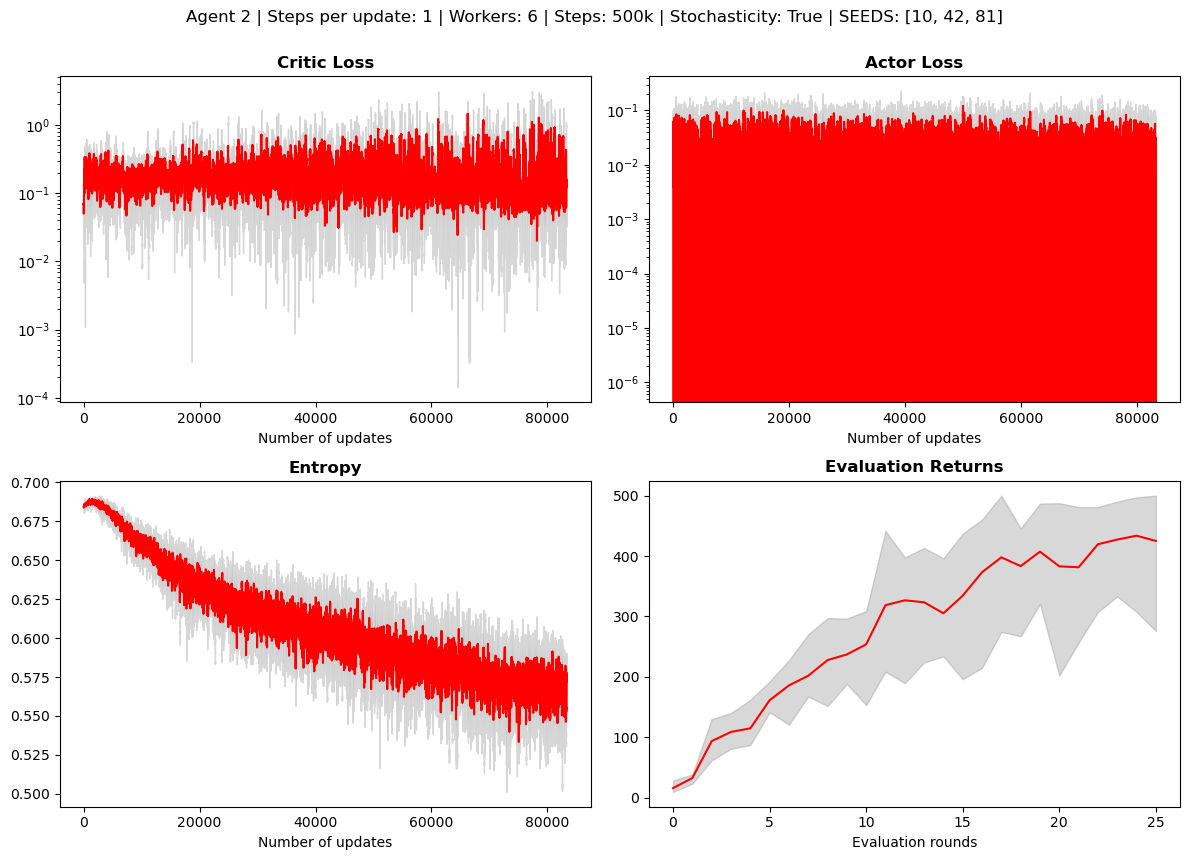

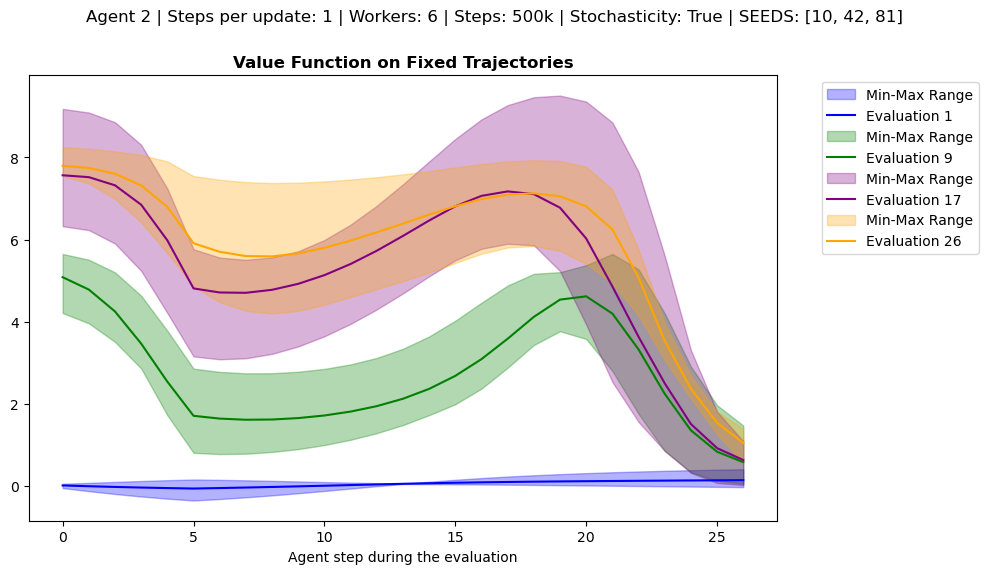

In [10]:
# Aggregate function for plotting the 3 seeds together
def aggregate_plot(y1,y2,y3):
    """
    Aggregates three input curves by computing the element-wise minimum, maximum, and average.

    Parameters:
    y1, y2, y3: np.ndarray
        Input arrays representing the three curves to be aggregated. Each array should have the same shape.

    Returns:
    y_min, y_max, y_avg: np.ndarray
        The element-wise minimum / maximum / average of the three input curves.
    """

    # Compute minimum and maximum curves
    y_min = np.minimum(np.minimum(y1, y2), y3)
    y_max = np.maximum(np.maximum(y1, y2), y3)

    # Compute average curve
    y_avg = (y1 + y2 + y3) / 3

    return y_min, y_max, y_avg

rolling_length = 30 # Rolling length for the convolution

# Arrays for the value function trajectories
values_arr = np.array(values) # Transforming the list to a numpy array ==> Values_arr of size (n_seeds, n_eval_done, steps_in_trajectory, 1)
values_sq = np.squeeze(values_arr) # Now of size (n_seeds, n_eval_done, steps_in_trajectory)
n_eval_done = values_sq.shape[1] # Number of evaluations done 
steps_in_trajectory = values_sq.shape[2] # Amount of steps in the trajectories of the value function
n_traj = 4 # Amount of value function trajectories to be plotted

# The code below is to select n_traj evenly spaced trajectories to plot between the first and last evaluation
if n_eval_done >= n_traj:
    idx_traj = np.linspace(0, n_eval_done - 1, n_traj, dtype='int') # Selecting n_traj trajectories evenly spaced between the first and last
else:
    idx_traj = np.arange(n_eval_done) # in case there are less evaluations than trajectories to plot, plot all evaluations

n_traj = len(idx_traj) # No matter how many trajectories where found, n_traj is updated to the actual length of the idx_traj
val_array = np.zeros((n_seeds, n_traj, steps_in_trajectory)) # Array to store the values of the selected trajectories
val_array = values_sq[:,idx_traj] # of size n_seeds, n_traj, steps_in_trajectory => contains only the values of the selected trajectories

traj_aggregates = np.zeros((n_seeds, n_traj, steps_in_trajectory)) # Will receive the values of y_min, y_max and y_avg for each of the n_traj for each seed


# Creating the lists for the aggregation
critic_y =[[] for _ in range(n_seeds)]
actor_y =[[] for _ in range(n_seeds)]
entropy_y =[[] for _ in range(n_seeds)]
evaluation_returns_seeds = np.array(evaluation_returns_seeds)


# Aggregating the losses and entropy while performing convolution
for s, agent_seed in enumerate(agents_seeds):
    critic_y[s] = (
        np.convolve(np.array(critic_losses[:,s]), np.ones(rolling_length), mode="valid")
        / rolling_length)
    actor_y[s] = (
        np.convolve(np.array(actor_losses[:,s]), np.ones(rolling_length), mode="valid")
        / rolling_length)
    entropy_y[s] = (
        np.convolve(np.array(entropies[:,s]), np.ones(rolling_length), mode="valid")
        / rolling_length
    )
    
# Building the y_min, y_max and y_avg for each of the plots
critic_y_min, critic_y_max, critic_y_avg = aggregate_plot(critic_y[0],critic_y[1],critic_y[2])
actor_y_min, actor_y_max, actor_y_avg = aggregate_plot(actor_y[0],actor_y[1],actor_y[2])
entropy_y_min, entropy_y_max, entropy_y_avg = aggregate_plot(entropy_y[0],entropy_y[1],entropy_y[2])
reward_y_min, reward_y_max, reward_y_avg = aggregate_plot(evaluation_returns_seeds[0], evaluation_returns_seeds[1], evaluation_returns_seeds[2])

# x values for the plots
critic_x = np.arange(0, critic_y_min.shape[0])
actor_x = np.arange(0, actor_y_min.shape[0]) # Not necessary
entropy_x = np.arange(0, entropy_y_min.shape[0]) # Not necessary
reward_x = np.arange(0, reward_y_min.shape[0])
traj_x = np.arange(0, steps_in_trajectory)
#ep_return_x = np.arange(0, ep_return_y_min.shape[0])
for j in range(n_traj): # Storing the y_min, y_max and y_avg of each of the n_traj trajectories
    traj_aggregates[0,j], traj_aggregates[1,j], traj_aggregates[2,j], = aggregate_plot(val_array[0][j], val_array[1][j], val_array[2][j])

""" Plotting the losses, entropy and returns"""
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 9))
fig.suptitle(f"Agent {id_agent} | Steps per update: {n_steps_per_update} | Workers: {n_envs} | Steps: {n_steps//1000}k | Stochasticity: {stochasticity_bool} | SEEDS: {agents_seeds}", x=0.5, fontsize = 12)

# Critic loss
axs[0, 0].fill_between(critic_x,critic_y_min, critic_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[0, 0].plot(critic_x, critic_y_avg, color='red', label='Average Curve')
axs[0, 0].set_title('Critic Loss', fontweight='bold')
axs[0, 0].set_yscale('log')  # Set log scale for the y-axis
axs[0, 0].set_xlabel("Number of updates")

# Actor loss
axs[0, 1].fill_between(actor_x,actor_y_min, actor_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[0, 1].plot(actor_x, actor_y_avg, color='red', label='Average Curve')
axs[0, 1].set_title('Actor Loss', fontweight='bold')
axs[0, 1].set_yscale('log')  # Set log scale for the y-axis
axs[0, 1].set_xlabel("Number of updates")

# Entropy
axs[1, 0].fill_between(entropy_x,entropy_y_min, entropy_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[1, 0].plot(entropy_x, entropy_y_avg, color='red', label='Average Curve')
axs[1, 0].set_title("Entropy", fontweight='bold')
axs[1, 0].set_xlabel("Number of updates")

# Evaluation rewards
axs[1, 1].fill_between(reward_x,reward_y_min, reward_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[1, 1].plot(reward_x, reward_y_avg, color='red', label='Average Curve')
axs[1, 1].set_title('Evaluation Returns', fontweight='bold')
axs[1, 1].set_xlabel("Evaluation rounds")

#plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig(f'figures/Agent{id_agent}_Losses&Returns.png', bbox_inches='tight')
plt.show()


"""Plotting the value function along the predefined fixed trajectory"""

colors = ['blue', 'green', 'purple', 'orange', 'black', 'yellow', 'pink', 'brown', 'cyan', 'magenta']

plt.figure(figsize=(10, 6))

for j in range(len(idx_traj)):
    plt.fill_between(traj_x, traj_aggregates[0,j], traj_aggregates[1,j], color = colors[j], alpha=0.3, label='Min-Max Range')
    plt.plot(traj_x, traj_aggregates[2,j,:], color=colors[j], label=f"Evaluation {idx_traj[j]+1}")

plt.suptitle(f"Agent {id_agent} | Steps per update: {n_steps_per_update} | Workers: {n_envs} | Steps: {n_steps//1000}k | Stochasticity: {stochasticity_bool} | SEEDS: {agents_seeds}", x=0.5, fontsize = 12)
plt.title('Value Function on Fixed Trajectories', fontweight='bold')
plt.xlabel('Agent step during the evaluation')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig(f'figures/Agent{id_agent}_Trajectories.png', bbox_inches='tight')
#plt.savefig(f'figures/Agent{id_agent}_Trajectories-&-{n_steps//1000}k_steps-&-{n_envs}_workers-&-{n_steps_per_update}_steps-per-update.png', bbox_inches='tight')
plt.show()

# Agent 3 (K = 1 | n = 6)

## 3.1 PARAMETERS SETUP


In [11]:
# utils functions 
def set_seed(seed):
    torch.manual_seed(seed) # pytorch random seed
    np.random.seed(seed) # numpy random seed

def getTrajectory():
    # create a new sample environment to get new random parameters
    env = gym.make("CartPole-v1", max_episode_steps=500)
    states = []
    # get an initial state
    state, info = env.reset(seed=40) # Seed n°40 allows to have the same sufficiently long trajectory across runs 
    states.append(state)
    done = False
    # play one episode
    done = False
    for i in range(5):
        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        state, reward, terminated, truncated, info = env.step(0) # only pushes left (0 is left, 1 is right)
        states.append(state)
    while not done:
        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        state, reward, terminated, truncated, info = env.step(1) # only pushes left (0 is left, 1 is right)
        states.append(state)
        done = terminated or truncated
        
    env.close()
    return states

# HYPERPARAMETERS
# environment hyperparams
n_steps = 500000
n_envs = 1
n_steps_per_update = 6
n_updates = n_steps // (n_steps_per_update*n_envs)
evaluation_interval = 20000//(n_steps_per_update*n_envs) # evaluate the agent every 20k steps
n_eval_runs = 10 # how many evaluation runs to do each 20k steps 
n_evaluations = n_updates // evaluation_interval

# Aggregate parameters
n_seeds = 3 # number of random seeds for the aggregation of plots
agents_seeds = [10, 42, 81] # Arbitrary seeds for the agents

# agent hyperparams
gamma = 0.99  # discount factor
ent_coef = 0.01  # coefficient for the entropy bonus (to encourage exploration)
actor_lr = 1e-5
critic_lr = 1e-3
stochasticity_bool = True
stochastic_reward_probability = 0.9
# Note: the actor has a slower learning rate so that the value targets become
# more stationary and are theirfore easier to estimate for the critic

# SEED
# Set a seed value
seed_value = 50
set_seed(seed_value)

# ENVIRONMENT
id_agent = "3" # ID of the Agent for the report [1:6]
envs = []
for i in range(n_envs):
    env = gym.make('CartPole-v1')
    envs.append(env)

env_eval = gym.make("CartPole-v1")
obs_shape = env_eval.observation_space.shape[0]
action_shape = env_eval.action_space.n

# DEVICE
use_cuda = False
if use_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

## 3.2 AGENT TRAINING

In [12]:
# LOGGED VARIABLES

# per seed
critic_losses = np.zeros((n_updates+1, n_seeds))
actor_losses = np.zeros((n_updates+1, n_seeds))
entropies = np.zeros((n_updates+1, n_seeds))
values = [[] for _ in range(n_seeds)] # logs the values of the agent on the fixed trajectory
evaluation_returns_seeds = [[] for _ in range(n_seeds)]

# per worker (not used in the plots)
episode_returns = [[] for _ in range(n_envs)] # logs the returns per episode per worker
steps_episodes = [[] for _ in range(n_envs)] # logs the steps taken in each episode per worker


fixed_trajectory = getTrajectory()

for s, agent_seed in enumerate(agents_seeds):
    print(f"Running seed {agent_seed} for agent {s}")
    agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr, n_envs)

    # COUNTERS
    steps = 0
    steps_workers = [0] * n_envs
    ep_counter = 0
    ep_reward = [0] * n_envs

    # VARIABLE INITIALIZATION
    is_truncated = [False] * n_envs #creates a list of n_envs elements, all set to False
    is_terminated = [False] * n_envs #creates a list of n_envs elements, all set to False
    states = []

    set_seed(agent_seed)
    for i in range(n_envs):
        state, info = envs[i].reset(seed=agent_seed)  #only use the seed when resetting the first time
        states.append(state)


    # use tqdm to get a progress bar for training
    for steps in tqdm(range(n_updates+1)):
            

        # reset lists that collect experiences of a n_steps_per_update
        n_value_preds = torch.zeros(n_steps_per_update, n_envs, device=device)
        n_action_log_probs = torch.zeros(n_steps_per_update, n_envs, device=device)
        # don't take mask and reward gradient
        masks = torch.ones(n_steps_per_update, n_envs, device=device,requires_grad = False)
        n_rewards = torch.zeros(n_steps_per_update, n_envs, device=device,requires_grad = False)
        end_states = [[] for _ in range(n_envs)] # get a list for each env ex : [[], [], []]
        end_states_idx = [[0] for _ in range(n_envs)] # get a list for each env ex : [[0], [0], [0]]

        # play n_steps_per_update to collect data
        for step in range(n_steps_per_update):
            entropy = [0] * n_envs
            for env_idx in range(n_envs):
                # select an action A_{t} using S_{t} as input for the agent, get action and values Vt
                action, action_log_probs, V_t, entropy[env_idx] = agent.select_action(states[env_idx], bool_greedy=False)

                # ensure no grad is taken in the step
                with torch.no_grad():
                    # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
                    states[env_idx], reward, is_terminated[env_idx], is_truncated[env_idx], infos = envs[env_idx].step(
                        action.cpu().numpy()
                    )
                    steps_workers[env_idx] += 1
                if stochasticity_bool:
                    # introduce stochasticity in the reward
                    if np.random.rand() < stochastic_reward_probability:
                        reward = 0

                ep_reward[env_idx] += reward # increase episode return
                mask = not is_terminated[env_idx] # define mask for bootstrapping

                # log the value, reward and action log prob of the last step
                n_value_preds[step][env_idx] = torch.squeeze(V_t)
                n_rewards[step][env_idx] = torch.tensor(reward, device=device)
                n_action_log_probs[step][env_idx] = action_log_probs

                # for each env the mask is 1 if the episode is ongoing and 0 if it is terminated (not by truncation!)
                masks[step][env_idx] = torch.tensor(mask) # allows for correct bootstrapping
                
                # reset environment if truncated or terminated
                if is_terminated[env_idx] or is_truncated[env_idx]:
                    states_tensor = torch.tensor(states[env_idx], device=device) # Transform the last state reached (S_t+n) to a tensor
                    end_states[env_idx].append(states_tensor)
                    end_states_idx[env_idx].append(step)
                    states[env_idx], info = envs[env_idx].reset() # do not use the seed when resetting again
                    ep_counter += 1
                    steps_episodes[env_idx].append(steps_workers[env_idx])
                    episode_returns[env_idx].append(ep_reward[env_idx])
                    ep_reward[env_idx] = 0

        
        for env_idx in range(n_envs):
            # if statement to make sure we don't append the end state twice
            if not is_terminated[env_idx] and not is_truncated[env_idx]:
                states_tensor = torch.tensor(states[env_idx], device=device) # Transform the last state reached (S_t+n) to a tensor
                end_states[env_idx].append(states_tensor)
                end_states_idx[env_idx].append(step)

        # calculate the losses for actor and critic
        critic_loss, actor_loss = agent.get_losses(
            n_rewards,
            n_action_log_probs,
            n_value_preds,
            entropy,
            masks,
            gamma,
            end_states,
            end_states_idx
        )

        # update the actor and critic networks
        agent.update_parameters(critic_loss, actor_loss)


        # log the losses and entropy
        critic_losses[steps, s] = critic_loss.detach().cpu().numpy()
        actor_losses[steps, s] = actor_loss.detach().cpu().numpy()
        entropies[steps, s] = sum(entropy) / len(entropy)


        #After every 20k steps, evaluate the performance of your agent by running it for 10 episodes with a greedy action policy (without noise)
        #on a newly initialized environment and plotting the evaluation statistics below.
        with torch.no_grad(): # No need to store gradients in the evaluation
            if steps % evaluation_interval == 0:
                print("EVALUATION")
                # evaluate
                returns = []
                episode_lengths = []
                for i in range(n_eval_runs):
                    # Only use the seed when resetting at the beginning to ensure the states will follow the same initialization at every evalutaion step
                    if i == 0:
                        state, info = env_eval.reset(seed = agent_seed)
                        value = []
                        for state_traj in fixed_trajectory:
                            _, _, V_t, _ = agent.select_action(state_traj, bool_greedy=False)
                            value.append(V_t)
                        values[s].append(value)
                        
                    else:
                        state, info = env_eval.reset()
                    episode_return = 0
                    episode_length = 0
                    while True:
                        action, _, _, _ = agent.select_action(state,bool_greedy=True)
                        state, reward, terminated, truncated, info = env_eval.step(action.cpu().numpy())
                        episode_return += reward
                        episode_length += 1
                        if terminated or truncated:
                            break
                    returns.append(episode_return)
                    episode_lengths.append(episode_length)  
                evaluation_returns_seeds[s].append(np.mean(returns))
                
# Logging variables for each agent
values_agent_3 = values.copy()
critic_losses_agent_3 = critic_losses.copy()
actor_losses_agent_3 = actor_losses.copy()
entropies_agent_3 = entropies.copy()
evaluation_returns_seeds_agent_3 = evaluation_returns_seeds.copy()




Running seed 10 for agent 0


  0%|          | 33/83334 [00:00<04:15, 326.46it/s]

EVALUATION


  4%|▍         | 3357/83334 [00:07<04:02, 329.82it/s]

EVALUATION


  8%|▊         | 6624/83334 [00:14<03:01, 422.61it/s]

EVALUATION


 12%|█▏        | 9957/83334 [00:22<02:41, 455.30it/s]

EVALUATION


 16%|█▌        | 13316/83334 [00:30<02:48, 416.08it/s]

EVALUATION


 20%|█▉        | 16661/83334 [00:39<02:36, 425.74it/s]

EVALUATION


 24%|██▍       | 19965/83334 [00:47<02:27, 430.57it/s]

EVALUATION


 28%|██▊       | 23319/83334 [00:56<02:30, 399.18it/s]

EVALUATION


 32%|███▏      | 26629/83334 [01:04<02:10, 436.02it/s]

EVALUATION


 36%|███▌      | 29957/83334 [01:12<02:17, 388.44it/s]

EVALUATION


 40%|███▉      | 33306/83334 [01:21<02:05, 398.85it/s]

EVALUATION


 44%|████▍     | 36639/83334 [01:30<01:52, 416.05it/s]

EVALUATION


 48%|████▊     | 39959/83334 [01:38<01:45, 411.18it/s]

EVALUATION


 52%|█████▏    | 43299/83334 [01:47<01:30, 444.15it/s]

EVALUATION


 56%|█████▌    | 46655/83334 [01:55<01:26, 426.34it/s]

EVALUATION


 60%|█████▉    | 49963/83334 [02:03<01:15, 439.21it/s]

EVALUATION


 64%|██████▍   | 53291/83334 [02:11<01:13, 408.33it/s]

EVALUATION


 68%|██████▊   | 56640/83334 [02:19<01:02, 427.83it/s]

EVALUATION


 72%|███████▏  | 59976/83334 [02:28<00:58, 396.66it/s]

EVALUATION


 76%|███████▌  | 63319/83334 [02:36<00:44, 445.87it/s]

EVALUATION


 80%|███████▉  | 66649/83334 [02:44<00:36, 459.31it/s]

EVALUATION


 84%|████████▍ | 69978/83334 [02:52<00:31, 419.83it/s]

EVALUATION


 88%|████████▊ | 73290/83334 [03:00<00:21, 461.01it/s]

EVALUATION


 92%|█████████▏| 76637/83334 [03:08<00:15, 444.10it/s]

EVALUATION


 96%|█████████▌| 79977/83334 [03:16<00:07, 437.09it/s]

EVALUATION


100%|█████████▉| 83297/83334 [03:25<00:00, 438.65it/s]

EVALUATION


100%|██████████| 83334/83334 [03:25<00:00, 405.17it/s]


Running seed 42 for agent 1


  0%|          | 37/83334 [00:00<03:49, 363.14it/s]

EVALUATION


  4%|▍         | 3335/83334 [00:07<03:47, 351.93it/s]

EVALUATION


  8%|▊         | 6656/83334 [00:15<02:45, 462.48it/s]

EVALUATION


 12%|█▏        | 9998/83334 [00:22<02:40, 457.03it/s]

EVALUATION


 16%|█▌        | 13314/83334 [00:30<02:32, 457.87it/s]

EVALUATION


 20%|█▉        | 16620/83334 [00:37<02:27, 451.81it/s]

EVALUATION


 24%|██▍       | 19987/83334 [00:45<02:21, 447.56it/s]

EVALUATION


 28%|██▊       | 23303/83334 [00:53<02:51, 350.82it/s]

EVALUATION


 32%|███▏      | 26664/83334 [01:01<02:02, 460.77it/s]

EVALUATION


 36%|███▌      | 29974/83334 [01:09<01:57, 453.68it/s]

EVALUATION


 40%|███▉      | 33301/83334 [01:17<01:59, 417.80it/s]

EVALUATION


 44%|████▍     | 36643/83334 [01:25<02:05, 371.02it/s]

EVALUATION


 48%|████▊     | 39954/83334 [01:33<01:37, 446.62it/s]

EVALUATION


 52%|█████▏    | 43314/83334 [01:41<01:26, 464.46it/s]

EVALUATION


 56%|█████▌    | 46645/83334 [01:49<01:20, 457.32it/s]

EVALUATION


 60%|█████▉    | 49982/83334 [01:57<01:12, 461.78it/s]

EVALUATION


 64%|██████▍   | 53313/83334 [02:05<01:05, 459.36it/s]

EVALUATION


 68%|██████▊   | 56628/83334 [02:13<00:59, 446.74it/s]

EVALUATION


 72%|███████▏  | 59991/83334 [02:21<00:56, 412.49it/s]

EVALUATION


 76%|███████▌  | 63310/83334 [02:29<00:47, 423.52it/s]

EVALUATION


 80%|███████▉  | 66639/83334 [02:38<00:39, 423.95it/s]

EVALUATION


 84%|████████▍ | 69989/83334 [02:46<00:32, 411.13it/s]

EVALUATION


 88%|████████▊ | 73302/83334 [02:54<00:21, 460.86it/s]

EVALUATION


 92%|█████████▏| 76632/83334 [03:02<00:14, 463.78it/s]

EVALUATION


 96%|█████████▌| 79987/83334 [03:10<00:07, 435.20it/s]

EVALUATION


100%|█████████▉| 83286/83334 [03:18<00:00, 462.95it/s]

EVALUATION


100%|██████████| 83334/83334 [03:18<00:00, 419.66it/s]


Running seed 81 for agent 2


  0%|          | 79/83334 [00:00<03:25, 404.58it/s]

EVALUATION


  4%|▍         | 3360/83334 [00:07<03:56, 338.86it/s]

EVALUATION


  8%|▊         | 6673/83334 [00:14<04:09, 307.77it/s]

EVALUATION


 12%|█▏        | 9970/83334 [00:22<02:50, 429.68it/s]

EVALUATION


 16%|█▌        | 13296/83334 [00:29<02:41, 434.07it/s]

EVALUATION


 20%|█▉        | 16626/83334 [00:37<02:38, 421.65it/s]

EVALUATION


 24%|██▍       | 19964/83334 [00:45<02:26, 432.21it/s]

EVALUATION


 28%|██▊       | 23301/83334 [00:53<02:11, 455.10it/s]

EVALUATION


 32%|███▏      | 26664/83334 [01:01<02:04, 456.09it/s]

EVALUATION


 36%|███▌      | 29997/83334 [01:09<02:13, 399.35it/s]

EVALUATION


 40%|███▉      | 33303/83334 [01:17<01:49, 457.71it/s]

EVALUATION


 44%|████▍     | 36637/83334 [01:25<01:42, 456.87it/s]

EVALUATION


 48%|████▊     | 39969/83334 [01:33<01:32, 467.32it/s]

EVALUATION


 52%|█████▏    | 43314/83334 [01:41<01:27, 459.50it/s]

EVALUATION


 56%|█████▌    | 46661/83334 [01:49<01:18, 465.83it/s]

EVALUATION


 60%|█████▉    | 49978/83334 [01:57<01:12, 460.36it/s]

EVALUATION


 64%|██████▍   | 53312/83334 [02:04<01:08, 440.28it/s]

EVALUATION


 68%|██████▊   | 56627/83334 [02:12<00:59, 450.15it/s]

EVALUATION


 72%|███████▏  | 59963/83334 [02:20<00:53, 440.37it/s]

EVALUATION


 76%|███████▌  | 63307/83334 [02:28<00:44, 453.30it/s]

EVALUATION


 80%|███████▉  | 66625/83334 [02:37<00:37, 439.75it/s]

EVALUATION


 84%|████████▍ | 69985/83334 [02:45<00:32, 407.79it/s]

EVALUATION


 88%|████████▊ | 73315/83334 [02:53<00:22, 437.57it/s]

EVALUATION


 92%|█████████▏| 76648/83334 [03:02<00:15, 418.44it/s]

EVALUATION


 96%|█████████▌| 79990/83334 [03:10<00:08, 391.92it/s]

EVALUATION


100%|█████████▉| 83298/83334 [03:18<00:00, 464.49it/s]

EVALUATION


100%|██████████| 83334/83334 [03:19<00:00, 417.88it/s]


## 3.3 PLOTTING

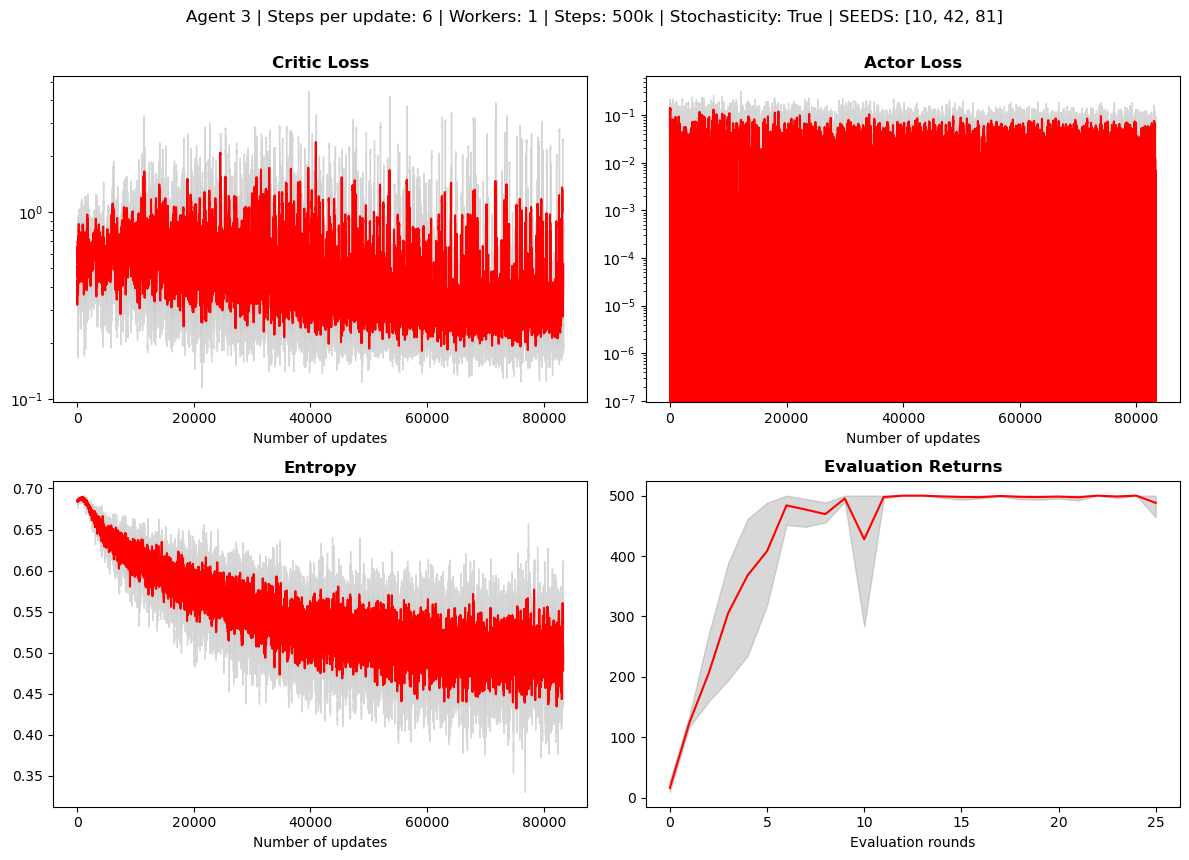

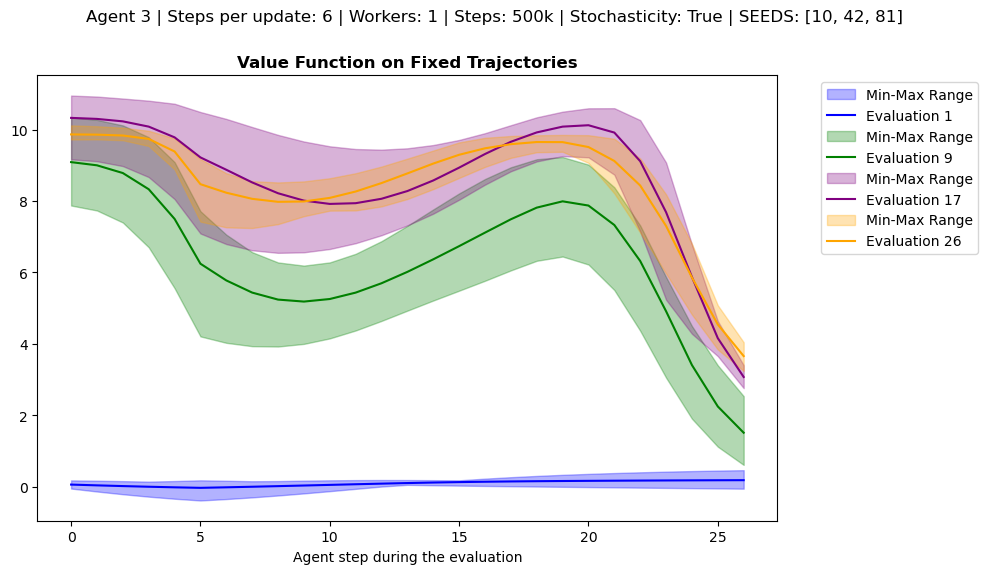

In [13]:
# Aggregate function for plotting the 3 seeds together
def aggregate_plot(y1,y2,y3):
    """
    Aggregates three input curves by computing the element-wise minimum, maximum, and average.

    Parameters:
    y1, y2, y3: np.ndarray
        Input arrays representing the three curves to be aggregated. Each array should have the same shape.

    Returns:
    y_min, y_max, y_avg: np.ndarray
        The element-wise minimum / maximum / average of the three input curves.
    """

    # Compute minimum and maximum curves
    y_min = np.minimum(np.minimum(y1, y2), y3)
    y_max = np.maximum(np.maximum(y1, y2), y3)

    # Compute average curve
    y_avg = (y1 + y2 + y3) / 3

    return y_min, y_max, y_avg

rolling_length = 30 # Rolling length for the convolution

# Arrays for the value function trajectories
values_arr = np.array(values) # Transforming the list to a numpy array ==> Values_arr of size (n_seeds, n_eval_done, steps_in_trajectory, 1)
values_sq = np.squeeze(values_arr) # Now of size (n_seeds, n_eval_done, steps_in_trajectory)
n_eval_done = values_sq.shape[1] # Number of evaluations done 
steps_in_trajectory = values_sq.shape[2] # Amount of steps in the trajectories of the value function
n_traj = 4 # Amount of value function trajectories to be plotted

# The code below is to select n_traj evenly spaced trajectories to plot between the first and last evaluation
if n_eval_done >= n_traj:
    idx_traj = np.linspace(0, n_eval_done - 1, n_traj, dtype='int') # Selecting n_traj trajectories evenly spaced between the first and last
else:
    idx_traj = np.arange(n_eval_done) # in case there are less evaluations than trajectories to plot, plot all evaluations

n_traj = len(idx_traj) # No matter how many trajectories where found, n_traj is updated to the actual length of the idx_traj
val_array = np.zeros((n_seeds, n_traj, steps_in_trajectory)) # Array to store the values of the selected trajectories
val_array = values_sq[:,idx_traj] # of size n_seeds, n_traj, steps_in_trajectory => contains only the values of the selected trajectories

traj_aggregates = np.zeros((n_seeds, n_traj, steps_in_trajectory)) # Will receive the values of y_min, y_max and y_avg for each of the n_traj for each seed


# Creating the lists for the aggregation
critic_y =[[] for _ in range(n_seeds)]
actor_y =[[] for _ in range(n_seeds)]
entropy_y =[[] for _ in range(n_seeds)]
evaluation_returns_seeds = np.array(evaluation_returns_seeds)


# Aggregating the losses and entropy while performing convolution
for s, agent_seed in enumerate(agents_seeds):
    critic_y[s] = (
        np.convolve(np.array(critic_losses[:,s]), np.ones(rolling_length), mode="valid")
        / rolling_length)
    actor_y[s] = (
        np.convolve(np.array(actor_losses[:,s]), np.ones(rolling_length), mode="valid")
        / rolling_length)
    entropy_y[s] = (
        np.convolve(np.array(entropies[:,s]), np.ones(rolling_length), mode="valid")
        / rolling_length
    )
    
# Building the y_min, y_max and y_avg for each of the plots
critic_y_min, critic_y_max, critic_y_avg = aggregate_plot(critic_y[0],critic_y[1],critic_y[2])
actor_y_min, actor_y_max, actor_y_avg = aggregate_plot(actor_y[0],actor_y[1],actor_y[2])
entropy_y_min, entropy_y_max, entropy_y_avg = aggregate_plot(entropy_y[0],entropy_y[1],entropy_y[2])
reward_y_min, reward_y_max, reward_y_avg = aggregate_plot(evaluation_returns_seeds[0], evaluation_returns_seeds[1], evaluation_returns_seeds[2])

# x values for the plots
critic_x = np.arange(0, critic_y_min.shape[0])
actor_x = np.arange(0, actor_y_min.shape[0]) # Not necessary
entropy_x = np.arange(0, entropy_y_min.shape[0]) # Not necessary
reward_x = np.arange(0, reward_y_min.shape[0])
traj_x = np.arange(0, steps_in_trajectory)
#ep_return_x = np.arange(0, ep_return_y_min.shape[0])
for j in range(n_traj): # Storing the y_min, y_max and y_avg of each of the n_traj trajectories
    traj_aggregates[0,j], traj_aggregates[1,j], traj_aggregates[2,j], = aggregate_plot(val_array[0][j], val_array[1][j], val_array[2][j])

""" Plotting the losses, entropy and returns"""
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 9))
fig.suptitle(f"Agent {id_agent} | Steps per update: {n_steps_per_update} | Workers: {n_envs} | Steps: {n_steps//1000}k | Stochasticity: {stochasticity_bool} | SEEDS: {agents_seeds}", x=0.5, fontsize = 12)

# Critic loss
axs[0, 0].fill_between(critic_x,critic_y_min, critic_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[0, 0].plot(critic_x, critic_y_avg, color='red', label='Average Curve')
axs[0, 0].set_title('Critic Loss', fontweight='bold')
axs[0, 0].set_yscale('log')  # Set log scale for the y-axis
axs[0, 0].set_xlabel("Number of updates")

# Actor loss
axs[0, 1].fill_between(actor_x,actor_y_min, actor_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[0, 1].plot(actor_x, actor_y_avg, color='red', label='Average Curve')
axs[0, 1].set_title('Actor Loss', fontweight='bold')
axs[0, 1].set_yscale('log')  # Set log scale for the y-axis
axs[0, 1].set_xlabel("Number of updates")

# Entropy
axs[1, 0].fill_between(entropy_x,entropy_y_min, entropy_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[1, 0].plot(entropy_x, entropy_y_avg, color='red', label='Average Curve')
axs[1, 0].set_title("Entropy", fontweight='bold')
axs[1, 0].set_xlabel("Number of updates")

# Evaluation rewards
axs[1, 1].fill_between(reward_x,reward_y_min, reward_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[1, 1].plot(reward_x, reward_y_avg, color='red', label='Average Curve')
axs[1, 1].set_title('Evaluation Returns', fontweight='bold')
axs[1, 1].set_xlabel("Evaluation rounds")

#plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig(f'figures/Agent{id_agent}_Losses&Returns.png', bbox_inches='tight')
plt.show()


"""Plotting the value function along the predefined fixed trajectory"""

colors = ['blue', 'green', 'purple', 'orange', 'black', 'yellow', 'pink', 'brown', 'cyan', 'magenta']

plt.figure(figsize=(10, 6))

for j in range(len(idx_traj)):
    plt.fill_between(traj_x, traj_aggregates[0,j], traj_aggregates[1,j], color = colors[j], alpha=0.3, label='Min-Max Range')
    plt.plot(traj_x, traj_aggregates[2,j,:], color=colors[j], label=f"Evaluation {idx_traj[j]+1}")

plt.suptitle(f"Agent {id_agent} | Steps per update: {n_steps_per_update} | Workers: {n_envs} | Steps: {n_steps//1000}k | Stochasticity: {stochasticity_bool} | SEEDS: {agents_seeds}", x=0.5, fontsize = 12)
plt.title('Value Function on Fixed Trajectories', fontweight='bold')
plt.xlabel('Agent step during the evaluation')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig(f'figures/Agent{id_agent}_Trajectories.png', bbox_inches='tight')
#plt.savefig(f'figures/Agent{id_agent}_Trajectories-&-{n_steps//1000}k_steps-&-{n_envs}_workers-&-{n_steps_per_update}_steps-per-update.png', bbox_inches='tight')
plt.show()

# Agent 4 (K = 6 | n = 6)

## 4.1 PARAMETERS SETUP


In [20]:
# utils functions 
def set_seed(seed):
    torch.manual_seed(seed) # pytorch random seed
    np.random.seed(seed) # numpy random seed

def getTrajectory():
    # create a new sample environment to get new random parameters
    env = gym.make("CartPole-v1", max_episode_steps=500)
    states = []
    # get an initial state
    state, info = env.reset(seed=40) # Seed n°40 allows to have the same sufficiently long trajectory across runs 
    states.append(state)
    done = False
    # play one episode
    done = False
    for i in range(5):
        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        state, reward, terminated, truncated, info = env.step(0) # only pushes left (0 is left, 1 is right)
        states.append(state)
    while not done:
        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        state, reward, terminated, truncated, info = env.step(1) # only pushes left (0 is left, 1 is right)
        states.append(state)
        done = terminated or truncated
        
    env.close()
    return states

# HYPERPARAMETERS
# environment hyperparams
n_steps = 500000
n_envs = 6
n_steps_per_update = 6
n_updates = n_steps // (n_steps_per_update*n_envs)
evaluation_interval = 20000//(n_steps_per_update*n_envs) # evaluate the agent every 20k steps
n_eval_runs = 10 # how many evaluation runs to do each 20k steps 
n_evaluations = n_updates // evaluation_interval

# Aggregate parameters
n_seeds = 3 # number of random seeds for the aggregation of plots
agents_seeds = [10, 42, 81] # Arbitrary seeds for the agents

# agent hyperparams
gamma = 0.99  # discount factor
ent_coef = 0.01  # coefficient for the entropy bonus (to encourage exploration)
actor_lr = 1e-5
critic_lr = 1e-3
stochasticity_bool = True
stochastic_reward_probability = 0.9
# Note: the actor has a slower learning rate so that the value targets become
# more stationary and are theirfore easier to estimate for the critic

# SEED
# Set a seed value
seed_value = 50
set_seed(seed_value)

# ENVIRONMENT
id_agent = "4" # ID of the Agent for the report [1:6]
envs = []
for i in range(n_envs):
    env = gym.make('CartPole-v1')
    envs.append(env)

env_eval = gym.make("CartPole-v1")
obs_shape = env_eval.observation_space.shape[0]
action_shape = env_eval.action_space.n

# DEVICE
use_cuda = False
if use_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

## 4.2 AGENT TRAINING

In [21]:
# LOGGED VARIABLES

# per seed
critic_losses = np.zeros((n_updates+1, n_seeds))
actor_losses = np.zeros((n_updates+1, n_seeds))
entropies = np.zeros((n_updates+1, n_seeds))
values = [[] for _ in range(n_seeds)] # logs the values of the agent on the fixed trajectory
evaluation_returns_seeds = [[] for _ in range(n_seeds)]

# per worker (not used in the plots)
episode_returns = [[] for _ in range(n_envs)] # logs the returns per episode per worker
steps_episodes = [[] for _ in range(n_envs)] # logs the steps taken in each episode per worker


fixed_trajectory = getTrajectory()

for s, agent_seed in enumerate(agents_seeds):
    print(f"Running seed {agent_seed} for agent {s}")
    agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr, n_envs)

    # COUNTERS
    steps = 0
    steps_workers = [0] * n_envs
    ep_counter = 0
    ep_reward = [0] * n_envs

    # VARIABLE INITIALIZATION
    is_truncated = [False] * n_envs #creates a list of n_envs elements, all set to False
    is_terminated = [False] * n_envs #creates a list of n_envs elements, all set to False
    states = []

    set_seed(agent_seed)
    for i in range(n_envs):
        state, info = envs[i].reset(seed=agent_seed)  #only use the seed when resetting the first time
        states.append(state)


    # use tqdm to get a progress bar for training
    for steps in tqdm(range(n_updates+1)):
            

        # reset lists that collect experiences of a n_steps_per_update
        n_value_preds = torch.zeros(n_steps_per_update, n_envs, device=device)
        n_action_log_probs = torch.zeros(n_steps_per_update, n_envs, device=device)
        # don't take mask and reward gradient
        masks = torch.ones(n_steps_per_update, n_envs, device=device,requires_grad = False)
        n_rewards = torch.zeros(n_steps_per_update, n_envs, device=device,requires_grad = False)
        end_states = [[] for _ in range(n_envs)] # get a list for each env ex : [[], [], []]
        end_states_idx = [[0] for _ in range(n_envs)] # get a list for each env ex : [[0], [0], [0]]

        # play n_steps_per_update to collect data
        for step in range(n_steps_per_update):
            entropy = [0] * n_envs
            for env_idx in range(n_envs):
                # select an action A_{t} using S_{t} as input for the agent, get action and values Vt
                action, action_log_probs, V_t, entropy[env_idx] = agent.select_action(states[env_idx], bool_greedy=False)

                # ensure no grad is taken in the step
                with torch.no_grad():
                    # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
                    states[env_idx], reward, is_terminated[env_idx], is_truncated[env_idx], infos = envs[env_idx].step(
                        action.cpu().numpy()
                    )
                    steps_workers[env_idx] += 1
                if stochasticity_bool:
                    # introduce stochasticity in the reward
                    if np.random.rand() < stochastic_reward_probability:
                        reward = 0

                ep_reward[env_idx] += reward # increase episode return
                mask = not is_terminated[env_idx] # define mask for bootstrapping

                # log the value, reward and action log prob of the last step
                n_value_preds[step][env_idx] = torch.squeeze(V_t)
                n_rewards[step][env_idx] = torch.tensor(reward, device=device)
                n_action_log_probs[step][env_idx] = action_log_probs

                # for each env the mask is 1 if the episode is ongoing and 0 if it is terminated (not by truncation!)
                masks[step][env_idx] = torch.tensor(mask) # allows for correct bootstrapping
                
                # reset environment if truncated or terminated
                if is_terminated[env_idx] or is_truncated[env_idx]:
                    states_tensor = torch.tensor(states[env_idx], device=device) # Transform the last state reached (S_t+n) to a tensor
                    end_states[env_idx].append(states_tensor)
                    end_states_idx[env_idx].append(step)
                    states[env_idx], info = envs[env_idx].reset() # do not use the seed when resetting again
                    ep_counter += 1
                    steps_episodes[env_idx].append(steps_workers[env_idx])
                    episode_returns[env_idx].append(ep_reward[env_idx])
                    ep_reward[env_idx] = 0

        
        for env_idx in range(n_envs):
            # if statement to make sure we don't append the end state twice
            if not is_terminated[env_idx] and not is_truncated[env_idx]:
                states_tensor = torch.tensor(states[env_idx], device=device) # Transform the last state reached (S_t+n) to a tensor
                end_states[env_idx].append(states_tensor)
                end_states_idx[env_idx].append(step)

        # calculate the losses for actor and critic
        critic_loss, actor_loss = agent.get_losses(
            n_rewards,
            n_action_log_probs,
            n_value_preds,
            entropy,
            masks,
            gamma,
            end_states,
            end_states_idx
        )

        # update the actor and critic networks
        agent.update_parameters(critic_loss, actor_loss)


        # log the losses and entropy
        critic_losses[steps, s] = critic_loss.detach().cpu().numpy()
        actor_losses[steps, s] = actor_loss.detach().cpu().numpy()
        entropies[steps, s] = sum(entropy) / len(entropy)


        #After every 20k steps, evaluate the performance of your agent by running it for 10 episodes with a greedy action policy (without noise)
        #on a newly initialized environment and plotting the evaluation statistics below.
        with torch.no_grad(): # No need to store gradients in the evaluation
            if steps % evaluation_interval == 0:
                print("EVALUATION")
                # evaluate
                returns = []
                episode_lengths = []
                for i in range(n_eval_runs):
                    # Only use the seed when resetting at the beginning to ensure the states will follow the same initialization at every evalutaion step
                    if i == 0:
                        state, info = env_eval.reset(seed = agent_seed)
                        value = []
                        for state_traj in fixed_trajectory:
                            _, _, V_t, _ = agent.select_action(state_traj, bool_greedy=False)
                            value.append(V_t)
                        values[s].append(value)
                        
                    else:
                        state, info = env_eval.reset()
                    episode_return = 0
                    episode_length = 0
                    while True:
                        action, _, _, _ = agent.select_action(state,bool_greedy=True)
                        state, reward, terminated, truncated, info = env_eval.step(action.cpu().numpy())
                        episode_return += reward
                        episode_length += 1
                        if terminated or truncated:
                            break
                    returns.append(episode_return)
                    episode_lengths.append(episode_length)  
                evaluation_returns_seeds[s].append(np.mean(returns))
                
# Logging variables for each agent
values_agent_4 = values.copy()
critic_losses_agent_4 = critic_losses.copy()
actor_losses_agent_4 = actor_losses.copy()
entropies_agent_4 = entropies.copy()
evaluation_returns_seeds_agent_4 = evaluation_returns_seeds.copy()




Running seed 10 for agent 0


  0%|          | 0/13889 [00:00<?, ?it/s]

  0%|          | 7/13889 [00:00<03:25, 67.42it/s]

EVALUATION


  4%|▍         | 568/13889 [00:06<02:31, 87.85it/s]

EVALUATION


  8%|▊         | 1121/13889 [00:12<02:30, 84.93it/s]

EVALUATION


 12%|█▏        | 1673/13889 [00:19<02:28, 82.34it/s]

EVALUATION


 16%|█▌        | 2232/13889 [00:25<02:19, 83.27it/s]

EVALUATION


 20%|██        | 2783/13889 [00:32<02:19, 79.61it/s]

EVALUATION


 24%|██▍       | 3339/13889 [00:38<02:23, 73.28it/s]

EVALUATION


 28%|██▊       | 3897/13889 [00:45<02:09, 77.20it/s]

EVALUATION


 32%|███▏      | 4451/13889 [00:51<02:12, 71.05it/s]

EVALUATION


 36%|███▌      | 5002/13889 [00:58<02:05, 70.58it/s]

EVALUATION


 40%|████      | 5559/13889 [01:05<01:52, 74.07it/s]

EVALUATION


 44%|████▍     | 6116/13889 [01:11<01:43, 74.91it/s]

EVALUATION


 48%|████▊     | 6671/13889 [01:17<01:27, 82.82it/s]

EVALUATION


 52%|█████▏    | 7226/13889 [01:24<01:24, 78.69it/s]

EVALUATION


 56%|█████▌    | 7781/13889 [01:31<01:20, 75.80it/s]

EVALUATION


 60%|█████▉    | 8329/13889 [01:37<01:21, 67.82it/s]

EVALUATION


 64%|██████▍   | 8885/13889 [01:44<01:16, 65.54it/s]

EVALUATION


 68%|██████▊   | 9443/13889 [01:50<01:05, 68.22it/s]

EVALUATION


 72%|███████▏  | 9994/13889 [01:56<00:58, 67.01it/s]

EVALUATION


 76%|███████▌  | 10545/13889 [02:03<00:37, 89.37it/s]

EVALUATION


 80%|███████▉  | 11101/13889 [02:09<00:43, 64.33it/s]

EVALUATION


 84%|████████▍ | 11652/13889 [02:15<00:23, 93.24it/s]

EVALUATION


 88%|████████▊ | 12205/13889 [02:22<00:18, 93.14it/s]

EVALUATION


 92%|█████████▏| 12763/13889 [02:28<00:12, 88.58it/s]

EVALUATION


 96%|█████████▌| 13321/13889 [02:35<00:08, 64.29it/s]

EVALUATION


100%|█████████▉| 13877/13889 [02:41<00:00, 58.45it/s]

EVALUATION


100%|██████████| 13889/13889 [02:41<00:00, 85.85it/s]


Running seed 42 for agent 1


  0%|          | 7/13889 [00:00<03:29, 66.41it/s]

EVALUATION


  4%|▍         | 569/13889 [00:06<02:28, 89.74it/s]

EVALUATION


  8%|▊         | 1123/13889 [00:12<02:48, 75.76it/s]

EVALUATION


 12%|█▏        | 1678/13889 [00:19<02:28, 82.43it/s]

EVALUATION


 16%|█▌        | 2235/13889 [00:25<02:21, 82.61it/s]

EVALUATION


 20%|██        | 2783/13889 [00:32<02:40, 69.15it/s]

EVALUATION


 24%|██▍       | 3335/13889 [00:39<02:22, 74.10it/s]

EVALUATION


 28%|██▊       | 3888/13889 [00:45<02:29, 66.70it/s]

EVALUATION


 32%|███▏      | 4452/13889 [00:52<02:09, 72.87it/s]

EVALUATION


 36%|███▌      | 4993/13889 [00:59<01:45, 84.50it/s]

EVALUATION


 40%|███▉      | 5554/13889 [01:06<02:27, 56.36it/s]

EVALUATION


 44%|████▍     | 6113/13889 [01:13<01:57, 66.43it/s]

EVALUATION


 48%|████▊     | 6669/13889 [01:19<01:43, 69.88it/s]

EVALUATION


 52%|█████▏    | 7214/13889 [01:25<01:13, 91.35it/s]

EVALUATION


 56%|█████▌    | 7770/13889 [01:31<01:07, 91.32it/s]

EVALUATION


 60%|█████▉    | 8332/13889 [01:38<01:23, 66.19it/s]

EVALUATION


 64%|██████▍   | 8888/13889 [01:44<01:07, 74.41it/s]

EVALUATION


 68%|██████▊   | 9436/13889 [01:50<01:08, 65.36it/s]

EVALUATION


 72%|███████▏  | 9996/13889 [01:57<00:58, 66.18it/s]

EVALUATION


 76%|███████▌  | 10555/13889 [02:03<00:45, 73.45it/s]

EVALUATION


 80%|███████▉  | 11110/13889 [02:09<00:35, 77.57it/s]

EVALUATION


 84%|████████▍ | 11655/13889 [02:15<00:24, 89.82it/s]

EVALUATION


 88%|████████▊ | 12209/13889 [02:22<00:20, 81.16it/s]

EVALUATION


 92%|█████████▏| 12763/13889 [02:29<00:13, 85.69it/s]

EVALUATION


 96%|█████████▌| 13320/13889 [02:36<00:06, 85.00it/s]

EVALUATION


100%|█████████▉| 13877/13889 [02:43<00:00, 57.03it/s]

EVALUATION


100%|██████████| 13889/13889 [02:43<00:00, 84.98it/s]


Running seed 81 for agent 2


  0%|          | 7/13889 [00:00<03:37, 63.74it/s]

EVALUATION


  4%|▍         | 565/13889 [00:06<02:41, 82.47it/s]

EVALUATION


  8%|▊         | 1121/13889 [00:13<02:38, 80.72it/s]

EVALUATION


 12%|█▏        | 1672/13889 [00:19<02:33, 79.60it/s]

EVALUATION


 16%|█▌        | 2231/13889 [00:26<02:20, 83.25it/s]

EVALUATION


 20%|██        | 2780/13889 [00:32<02:25, 76.33it/s]

EVALUATION


 24%|██▍       | 3336/13889 [00:38<02:21, 74.45it/s]

EVALUATION


 28%|██▊       | 3888/13889 [00:44<02:14, 74.54it/s]

EVALUATION


 32%|███▏      | 4451/13889 [00:51<01:59, 78.83it/s]

EVALUATION


 36%|███▌      | 5001/13889 [00:57<02:09, 68.47it/s]

EVALUATION


 40%|███▉      | 5552/13889 [01:04<02:23, 57.97it/s]

EVALUATION


 44%|████▍     | 6110/13889 [01:10<01:55, 67.18it/s]

EVALUATION


 48%|████▊     | 6668/13889 [01:17<01:48, 66.81it/s]

EVALUATION


 52%|█████▏    | 7215/13889 [01:23<01:16, 87.72it/s]

EVALUATION


 56%|█████▌    | 7770/13889 [01:29<01:09, 88.48it/s]

EVALUATION


 60%|█████▉    | 8326/13889 [01:36<01:23, 66.76it/s]

EVALUATION


 64%|██████▍   | 8878/13889 [01:42<00:54, 91.21it/s]

EVALUATION


 68%|██████▊   | 9438/13889 [01:48<01:06, 67.35it/s]

EVALUATION


 72%|███████▏  | 9987/13889 [01:54<00:42, 91.79it/s]

EVALUATION


 76%|███████▌  | 10547/13889 [02:01<00:50, 66.48it/s]

EVALUATION


 80%|███████▉  | 11096/13889 [02:07<00:30, 92.00it/s]

EVALUATION


 84%|████████▍ | 11654/13889 [02:13<00:24, 90.50it/s]

EVALUATION


 88%|████████▊ | 12212/13889 [02:20<00:32, 51.92it/s]

EVALUATION


 92%|█████████▏| 12763/13889 [02:27<00:12, 87.48it/s]

EVALUATION


 96%|█████████▌| 13317/13889 [02:33<00:06, 87.85it/s]

EVALUATION


100%|█████████▉| 13870/13889 [02:40<00:00, 86.10it/s]

EVALUATION


100%|██████████| 13889/13889 [02:40<00:00, 86.35it/s]


## 4.3 PLOTTING

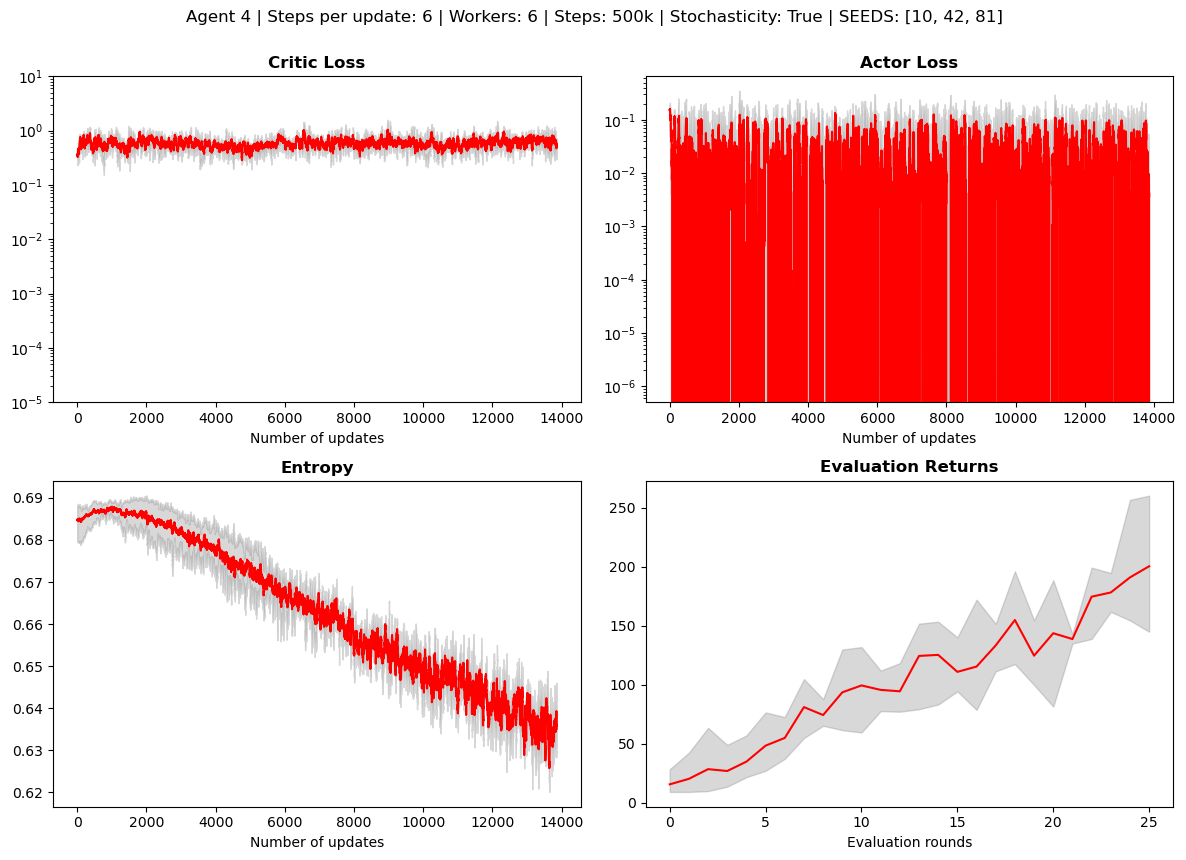

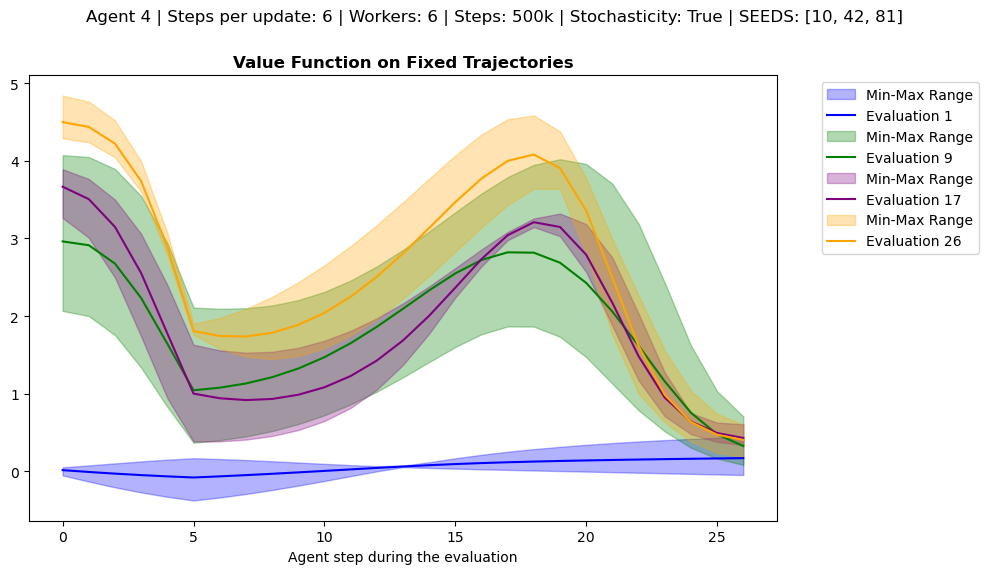

In [23]:
# Aggregate function for plotting the 3 seeds together
def aggregate_plot(y1,y2,y3):
    """
    Aggregates three input curves by computing the element-wise minimum, maximum, and average.

    Parameters:
    y1, y2, y3: np.ndarray
        Input arrays representing the three curves to be aggregated. Each array should have the same shape.

    Returns:
    y_min, y_max, y_avg: np.ndarray
        The element-wise minimum / maximum / average of the three input curves.
    """

    # Compute minimum and maximum curves
    y_min = np.minimum(np.minimum(y1, y2), y3)
    y_max = np.maximum(np.maximum(y1, y2), y3)

    # Compute average curve
    y_avg = (y1 + y2 + y3) / 3

    return y_min, y_max, y_avg

rolling_length = 30 # Rolling length for the convolution

# Arrays for the value function trajectories
values_arr = np.array(values) # Transforming the list to a numpy array ==> Values_arr of size (n_seeds, n_eval_done, steps_in_trajectory, 1)
values_sq = np.squeeze(values_arr) # Now of size (n_seeds, n_eval_done, steps_in_trajectory)
n_eval_done = values_sq.shape[1] # Number of evaluations done 
steps_in_trajectory = values_sq.shape[2] # Amount of steps in the trajectories of the value function
n_traj = 4 # Amount of value function trajectories to be plotted

# The code below is to select n_traj evenly spaced trajectories to plot between the first and last evaluation
if n_eval_done >= n_traj:
    idx_traj = np.linspace(0, n_eval_done - 1, n_traj, dtype='int') # Selecting n_traj trajectories evenly spaced between the first and last
else:
    idx_traj = np.arange(n_eval_done) # in case there are less evaluations than trajectories to plot, plot all evaluations

n_traj = len(idx_traj) # No matter how many trajectories where found, n_traj is updated to the actual length of the idx_traj
val_array = np.zeros((n_seeds, n_traj, steps_in_trajectory)) # Array to store the values of the selected trajectories
val_array = values_sq[:,idx_traj] # of size n_seeds, n_traj, steps_in_trajectory => contains only the values of the selected trajectories

traj_aggregates = np.zeros((n_seeds, n_traj, steps_in_trajectory)) # Will receive the values of y_min, y_max and y_avg for each of the n_traj for each seed


# Creating the lists for the aggregation
critic_y =[[] for _ in range(n_seeds)]
actor_y =[[] for _ in range(n_seeds)]
entropy_y =[[] for _ in range(n_seeds)]
evaluation_returns_seeds = np.array(evaluation_returns_seeds)


# Aggregating the losses and entropy while performing convolution
for s, agent_seed in enumerate(agents_seeds):
    critic_y[s] = (
        np.convolve(np.array(critic_losses[:,s]), np.ones(rolling_length), mode="valid")
        / rolling_length)
    actor_y[s] = (
        np.convolve(np.array(actor_losses[:,s]), np.ones(rolling_length), mode="valid")
        / rolling_length)
    entropy_y[s] = (
        np.convolve(np.array(entropies[:,s]), np.ones(rolling_length), mode="valid")
        / rolling_length
    )
    
# Building the y_min, y_max and y_avg for each of the plots
critic_y_min, critic_y_max, critic_y_avg = aggregate_plot(critic_y[0],critic_y[1],critic_y[2])
actor_y_min, actor_y_max, actor_y_avg = aggregate_plot(actor_y[0],actor_y[1],actor_y[2])
entropy_y_min, entropy_y_max, entropy_y_avg = aggregate_plot(entropy_y[0],entropy_y[1],entropy_y[2])
reward_y_min, reward_y_max, reward_y_avg = aggregate_plot(evaluation_returns_seeds[0], evaluation_returns_seeds[1], evaluation_returns_seeds[2])

# x values for the plots
critic_x = np.arange(0, critic_y_min.shape[0])
actor_x = np.arange(0, actor_y_min.shape[0]) # Not necessary
entropy_x = np.arange(0, entropy_y_min.shape[0]) # Not necessary
reward_x = np.arange(0, reward_y_min.shape[0])
traj_x = np.arange(0, steps_in_trajectory)
#ep_return_x = np.arange(0, ep_return_y_min.shape[0])
for j in range(n_traj): # Storing the y_min, y_max and y_avg of each of the n_traj trajectories
    traj_aggregates[0,j], traj_aggregates[1,j], traj_aggregates[2,j], = aggregate_plot(val_array[0][j], val_array[1][j], val_array[2][j])

""" Plotting the losses, entropy and returns"""
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 9))
fig.suptitle(f"Agent {id_agent} | Steps per update: {n_steps_per_update} | Workers: {n_envs} | Steps: {n_steps//1000}k | Stochasticity: {stochasticity_bool} | SEEDS: {agents_seeds}", x=0.5, fontsize = 12)

# Critic loss
axs[0, 0].fill_between(critic_x,critic_y_min, critic_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[0, 0].plot(critic_x, critic_y_avg, color='red', label='Average Curve')
axs[0, 0].set_title('Critic Loss', fontweight='bold')
axs[0, 0].set_yscale('log')  # Set log scale for the y-axis
axs[0, 0].set_ylim(1e-5, 1e1)
axs[0, 0].set_xlabel("Number of updates")

# Actor loss
axs[0, 1].fill_between(actor_x,actor_y_min, actor_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[0, 1].plot(actor_x, actor_y_avg, color='red', label='Average Curve')
axs[0, 1].set_title('Actor Loss', fontweight='bold')
axs[0, 1].set_yscale('log')  # Set log scale for the y-axis
axs[0, 1].set_xlabel("Number of updates")

# Entropy
axs[1, 0].fill_between(entropy_x,entropy_y_min, entropy_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[1, 0].plot(entropy_x, entropy_y_avg, color='red', label='Average Curve')
axs[1, 0].set_title("Entropy", fontweight='bold')
axs[1, 0].set_xlabel("Number of updates")

# Evaluation rewards
axs[1, 1].fill_between(reward_x,reward_y_min, reward_y_max, color='gray', alpha=0.3, label='Min-Max Range')
axs[1, 1].plot(reward_x, reward_y_avg, color='red', label='Average Curve')
axs[1, 1].set_title('Evaluation Returns', fontweight='bold')
axs[1, 1].set_xlabel("Evaluation rounds")

#plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig(f'figures/Agent{id_agent}_Losses&Returns.png', bbox_inches='tight')
plt.show()


"""Plotting the value function along the predefined fixed trajectory"""

colors = ['blue', 'green', 'purple', 'orange', 'black', 'yellow', 'pink', 'brown', 'cyan', 'magenta']

plt.figure(figsize=(10, 6))

for j in range(len(idx_traj)):
    plt.fill_between(traj_x, traj_aggregates[0,j], traj_aggregates[1,j], color = colors[j], alpha=0.3, label='Min-Max Range')
    plt.plot(traj_x, traj_aggregates[2,j,:], color=colors[j], label=f"Evaluation {idx_traj[j]+1}")

plt.suptitle(f"Agent {id_agent} | Steps per update: {n_steps_per_update} | Workers: {n_envs} | Steps: {n_steps//1000}k | Stochasticity: {stochasticity_bool} | SEEDS: {agents_seeds}", x=0.5, fontsize = 12)
plt.title('Value Function on Fixed Trajectories', fontweight='bold')
plt.xlabel('Agent step during the evaluation')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig(f'figures/Agent{id_agent}_Trajectories.png', bbox_inches='tight')
#plt.savefig(f'figures/Agent{id_agent}_Trajectories-&-{n_steps//1000}k_steps-&-{n_envs}_workers-&-{n_steps_per_update}_steps-per-update.png', bbox_inches='tight')
plt.show()